# Edge Cases: The Making of Network Navigator and Critical Approaches to DH Tools

 ### John R. Ladd [![orcid](https://orcid.org/sites/default/files/images/orcid_16x16.png)](https://orcid.org/0000-0002-5440-062X) 
Washington and Jefferson College

### Zoe LeBlanc [![orcid](https://orcid.org/sites/default/files/images/orcid_16x16.png)](https://orcid.org/0000-0003-2012-8805) 
University of Illinois Urbana-Champaign

[![cc-by-nc-nd](https://licensebuttons.net/l/by-nc-nd/4.0/88x31.png)](https://creativecommons.org/licenses/by-nc-nd/4.0/) 
© John R. Ladd and Zoe LeBlanc. Published by De Gruyter in cooperation with the University of Luxembourg Centre for Contemporary and Digital History. This is an Open Access article distributed under the terms of the [Creative Commons Attribution License CC-BY-NC-ND](https://creativecommons.org/licenses/by-nc-nd/4.0/)


In [ ]:
from IPython.display import Image 
metadata={
    "jdh": {
        "module": "object",
        "object": {
            "type":"image",
            "source": [
                "Cover image for article. Generated using Canva's AI Tool with the terms network analysis, digital humanities, and tools."
            ]
        }
    }
}
display(Image("media/cover_image.png"), metadata=metadata)

NetworkAnalysis, Networks, Visualization, Tools, DH

This article will explore the role of network analysis research tools as/in scholarly infrastructure, and also detail our attempt to intervene in these practices by building *Network Navigator*, a browser tool for network analysis. In making *Network Navigator*, we intentionally contributed to an existing ecosystem of network analysis tools, namely *Gephi* and *Palladio*, but we were also motivated to combine the principles of minimal computing with new developments in web architecture and DH. We believe our perspective helps complicate our understanding of “tool”-building, making visible the obscured interpretive work of DH infrastructure. Given the centrality of GUI tools in introductory DH pedagogy, we believe that the making and maintaining of DH tools remains one of the profoundly influential, and yet consistently under theorized, areas of DH scholarship and teaching. Even as tools seem to be so foundational to DH, at the same time they remain rarely debated or even defined as a category. Rather than treating ‘tools’ as simply technical objects, we want to critically examine how their design and materiality directly shapes this conceptual amorphousness, but also more profoundly how this definitional problem makes it difficult to discern the ways DH tools are determining larger DH systems and infrastructure.

## Nodes: Introducing the Network Navigator Tool and Intervening in Network Analysis Practices in DH

Since ‘Digital Humanities’ was first coined, debating the question of “what is Digital Humanities (DH)” has become so established that even asking it functions as a meta-discourse. And yet, even though the answers vary widely, many of them often include some reference to “DH tools.” 

To start to explore how tools have become so central in DH, this article utilizes a number of datasets, the first of which is Jason Heppler's dataset from `whatisdigitalhumanities.com`, accessed via https://github.com/hepplerj/whatisdigitalhumanities. This dataset contains quotations from the Day of DH between 2009-2014. As of January 2015, the database contains 817 rows. We used this dataset to explore how frequently the term tool is used in these definitions of DH.

To analyze this data, we first import the relevant libraries and check if we need to download additional packages for text analysis, as well as setting the path to our datasets and charts.

In [2]:
import pandas as pd
import os
import json
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

import altair as alt
alt.data_transformers.disable_max_rows()
alt.data_transformers.enable('json')
# Check if VS Code is running the script
if os.environ.get('VSCODE_PID') is not None:
    alt.renderers.enable('mimetype')
else:
    alt.renderers.enable('default')


import nltk
from nltk.tokenize import word_tokenize
## If you haven't downloaded the NLTK data sets yet, do so:
def download_nltk_data_if_needed(packages):
    for package in packages:
        try:
            nltk.data.find(package)
        except LookupError:
            nltk.download(package)

download_nltk_data_if_needed(['tokenizers/punkt', 'corpora/stopwords'])

article_data_directory_path = "./script/data/csvs/" # Where all the article datasets are stored
article_chart_directory_path = "./script/data/charts/" # Where all the article charts are stored

Then we read in the dataset and count the frequency of the word `tool` in the definitions. As Ted Underwood has argued, word counts, though seemingly very straightforward and even basic, can be a powerful tool for exploring change in language and deciding how to count requires many interpretative choices that can shape our results.(<cite data-cite="14009734/PNJPRYAP"></cite>) For a more detailed explanation of the methods we used, see our `CountingTools.ipynb` notebook, but primarily we are using a combination of *lowercasing* the textual data for consistency and then *tokenizing* this data, and finally searching for matches in these tokens. This choice is deliberate since our primary focus lies in identifying the frequency of tool names and related terms, such as "network analysis." Our goal is to capture as many instances as possible without being overly permissive and including unrelated words that merely contain these terms.

Furthermore, our choice to utilize word counting and not more complex methods is also intentional, since we are primarily interested in tracing the popularity of tools and network analysis in DH, and less interested in exploring how the language around these terms have changed (something we hope to explore in future work). 

In [3]:
# Define the path to the output CSV file
output_csv_path = f"{article_data_directory_path}heppler_data/whatisdh_df.csv"

# Check if the output CSV file exists
if os.path.exists(output_csv_path):
    # If it exists, load the data from the output CSV file
    whatisdh_quotes_df = pd.read_csv(output_csv_path)
else:
    # If it doesn't exist, load the data from the original CSV file
    whatisdh_quotes_df = pd.read_csv(f"{article_data_directory_path}heppler_data/dayofquotes_full.csv")

    # Add a 'quote_id' column based on the DataFrame index
    whatisdh_quotes_df['quote_id'] = whatisdh_quotes_df.index

    # Add a 'lower_quote' column with the lowercase version of the 'quote' column
    whatisdh_quotes_df['lower_quote'] = whatisdh_quotes_df['quote'].str.lower()

    # Add a 'lower_tokenized_quote' column with the tokenized version of the 'lower_quote' column
    whatisdh_quotes_df['lower_tokenized_quote'] = whatisdh_quotes_df['lower_quote'].apply(word_tokenize)

    # Convert the 'date' column to datetime format
    whatisdh_quotes_df['date'] = pd.to_datetime(whatisdh_quotes_df['date'])

    # Add a 'year' column based on the 'date' column
    whatisdh_quotes_df['year'] = whatisdh_quotes_df['date'].dt.year

    # Add a 'quote_length' column with the length of each tokenized quote
    whatisdh_quotes_df['quote_length'] = whatisdh_quotes_df['lower_tokenized_quote'].apply(len)

    # Add a 'tool_frequency' column with the count of 'tool' in each tokenized quote
    whatisdh_quotes_df['tool_frequency'] = whatisdh_quotes_df['lower_tokenized_quote'].apply(lambda x: sum([1 for token in x if 'tool' in token]))

    # Add a 'scaled_tool_frequency' column with the 'tool_frequency' scaled by the 'quote_length'
    whatisdh_quotes_df['scaled_tool_frequency'] = whatisdh_quotes_df['tool_frequency'] / whatisdh_quotes_df['quote_length']

    # Group the DataFrame by 'year' and calculate the sum of 'quote_length', 'tool_frequency', and 'scaled_tool_frequency' for each year
    yearly_tool_counts_df = whatisdh_quotes_df.groupby(['year']).agg({'quote_length': 'sum', 'tool_frequency': 'sum', 'scaled_tool_frequency': 'sum'}).reset_index()

    # Group the DataFrame by 'year' and calculate the total count for each year
    yearly_counts_df = whatisdh_quotes_df.groupby('year').size().reset_index(name='total_counts')

    # Group the DataFrame by 'year' and calculate the count of quotes with 'tool' for each year
    yearly_tool_whatisdh_quotes_df = whatisdh_quotes_df[whatisdh_quotes_df.tool_frequency > 0].groupby(['year']).size().reset_index(name='tool_counts')

    # Merge the total counts and tool counts DataFrames on the 'year' column
    merged_counts_df = pd.merge(yearly_counts_df, yearly_tool_whatisdh_quotes_df, on='year', how='outer')

    # Merge the merged counts DataFrame and the tool counts DataFrame on the 'year' column
    final_counts_whatisdh_df = pd.merge(merged_counts_df, yearly_tool_counts_df, on='year', how='outer')

    # Add a 'ratio' column with the ratio of 'tool_counts' to 'total_counts'
    final_counts_whatisdh_df['ratio'] = final_counts_whatisdh_df['tool_counts'] / final_counts_whatisdh_df['total_counts']

    # Reshape the DataFrame from wide format to long format, with 'year' and 'ratio' as the identifier variables, and 'total_counts' and 'tool_counts' as the variable names
    reshaped_whatisdh_df = pd.melt(final_counts_whatisdh_df, id_vars=['year', 'ratio'], value_vars=['total_counts', 'tool_counts'])

    # Replace 'total_counts' with 'Total Number of Quotes By Year' in the 'variable' column
    reshaped_whatisdh_df.loc[reshaped_whatisdh_df['variable'] == 'total_counts', 'variable'] = 'Total Number of Quotes By Year'

    # Replace 'tool_counts' with 'Total Number of Quotes Containing "Tool" By Year' in the 'variable' column
    reshaped_whatisdh_df.loc[reshaped_whatisdh_df['variable'] == 'tool_counts', 'variable'] = 'Total Number of Quotes Containing "Tool" By Year'

    # Write the DataFrame to the output CSV file
    whatisdh_quotes_df.to_csv(output_csv_path, index=False)

Finally, we visualize the results both over time and by correlation to the total number of words in each definition.

In [4]:
whatisdh_chart_output_path = f"{article_chart_directory_path}whatisdh_chart.json"

# Check if the chart file exists
if os.path.exists(whatisdh_chart_output_path):
    # Load the chart from the JSON file
    with open(whatisdh_chart_output_path) as json_file:
        whatisdh_chart_dict = json.load(json_file)
    whatisdh_chart = alt.Chart.from_dict(whatisdh_chart_dict)
else:
    # Create a bar chart
    time_chart = alt.Chart(reshaped_whatisdh_df).mark_bar().encode(
        x=alt.X('year:O', title='Year', axis=alt.Axis(labelAngle=0)),
        y=alt.Y('value:Q', title='Total number of quotes defining DH'),
        color=alt.Color('variable:N', legend=alt.Legend(title='', orient='bottom', symbolLimit=0, labelLimit=400)),
        tooltip=[
            alt.Tooltip('year', title='Year'),
            alt.Tooltip('value', title='Total Number of Quotes'),
            alt.Tooltip('variable', title='Quote Category'),
            alt.Tooltip('ratio', title='Ratio of Quotes', format='.2f')
        ]
    ).properties(
        title={'text': 'Change in Number of Quotes Containing "Tool" Over Time', 'fontSize': 12},
        width=400,
        height=300
    )

    # Define the dependent and independent variables
    X = final_counts_whatisdh_df['tool_frequency']
    y = final_counts_whatisdh_df['quote_length']

    # Add a constant to the independent variable
    X = sm.add_constant(X)

    # Perform the OLS regression
    model = sm.OLS(y, X)
    results = model.fit()

    # Get the R-squared value
    r_squared = results.rsquared

    # Create the chart
    chart = alt.Chart(final_counts_whatisdh_df).mark_circle().encode(
        x=alt.X('tool_frequency', axis=alt.Axis(title='Frequency of "tool" in any quote defining DH')),
        y=alt.Y('quote_length', axis=alt.Axis(title='Length of any quote defining DH')),
        color=alt.Color('year:N', legend=alt.Legend(title='Year of Quote'), scale=alt.Scale(scheme='plasma')),
        size='ratio',
        tooltip=[
            alt.Tooltip('year', title='Year'),
            alt.Tooltip('tool_frequency', title='Frequency of Tool in Quote'),
            alt.Tooltip('quote_length', title='Quote Length'),
            alt.Tooltip('scaled_tool_frequency', title='Scaled Frequency of Tool in Quote', format='.2f'),
        ]
    ).properties(
        title={'text': 'Correlation Between Frequency of "Tool" in Quotes', 'fontSize': 12},
        width=300,
    )

    # Add the regression line
    combined_chart = chart + chart.transform_regression('tool_frequency', 'quote_length', method="linear").mark_line(color='red').encode(color=alt.Color(legend=None))

    # Add the R-squared value as a text mark
    text = alt.Chart({'values':[{'x': 0, 'y': 0}]}).mark_text(
        text=f'R-squared: {r_squared:.2f}',
        align='left',
        baseline='top',
        color='black',
        dx=5  # Nudges text to right so it doesn't appear on top of the bar
    ).encode(
        x=alt.value(0),  # pixels from left
        y=alt.value(0),  # pixels from top
    )

    # Combine the charts
    final_chart = combined_chart + text

    whatisdh_chart = (alt.hconcat(time_chart, final_chart).resolve_scale(color='independent', y="independent").properties(title="Frequency of 'Tool' in Quotes From whatisdigitalhumanities.com and Day of DH").configure(
            title=alt.TitleConfig(fontSize=20, font='Garamond', anchor='middle'),
            axis=alt.AxisConfig(labelFont='Garamond', titleFont='Garamond'),
            legend=alt.LegendConfig(labelFont='Garamond', titleFont='Garamond')
        ))
    whatisdh_chart.save(whatisdh_chart_output_path)

In [5]:
whatisdh_chart

alt.HConcatChart(...)

The first graph shows that the term tool is used more frequently in the definitions of DH over time, and the second graph shows that this frequency has a positive correlation as quotes get longer over time. This suggests that the term tool is becoming more central to the definition of DH, even as definitions of DH become more verbose.

In addition to frequency, we can also look at the words themselves though generating a word cloud. We can see that the word "tool" is one of the most common words in the definitions of DH.

In [6]:
wordcloud_path = f"{article_chart_directory_path}whatisdh_wordcloud.png"
rerun_chart_code = False

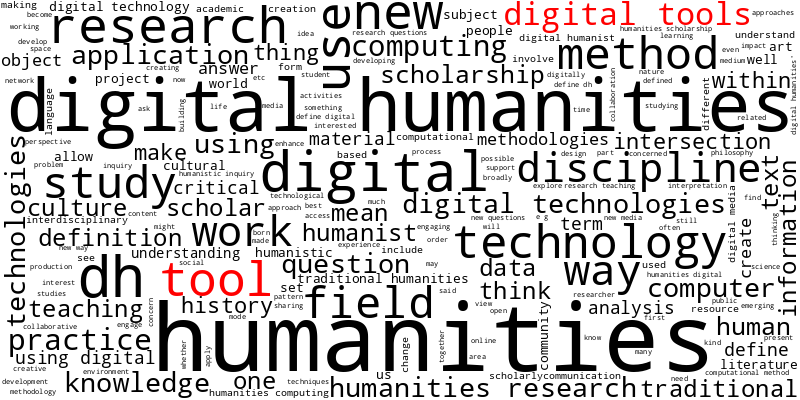

In [7]:
if os.path.exists(wordcloud_path) == False or rerun_chart_code:
    # Import the wordcloud library and matplotlib
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt

    # Define a function to color the word cloud
    def color_func(word, **kwargs):
        if 'tool' in word:
            return 'red'
        else:
            return 'black'

    # Join the 'lower_quote' column into a single string
    text = ' '.join(whatisdh_quotes_df.lower_quote.astype(str))
    # Create the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color ='white', color_func=color_func).generate(text)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off the axis
    plt.show()
    wordcloud.to_file(wordcloud_path)
else:
    from IPython.display import Image 
    metadata={
        "jdh": {
            "module": "object",
            "object": {
                "type":"image",
                "source": [
                    "Word cloud of all quotes from whatisdigitalhumanities.com and Day of DH, with the word \"tool\" highlighted in red."
                ]
            }
        }
    }
    display(Image(wordcloud_path), metadata=metadata)

In this graph, we can see that `tool` and `digital tools` are both prominently sized in the word cloud, suggesting that the term tool is used relatively frequently in the definitions of DH. While such word counts and word clouds are not definitive, these methods help suggest that this trend exists and is worth further investigation. 

While the exact tools referenced have changed over time, increasingly many of those most consistently used and cited have been tools intended for network analysis.  

In addition to looking at the popularity of `tool`, we can also explore the popularity of tools specifically for network analysis in DH. To do this, we identified a list of tools for network analysis in DH, based partially on our own experiences and through the list available on the Text Analysis Portal for Research (TAPoR) at http://tapor.ca/tools/category/Network%20Analysis. We did not include tools that are primarily for data visualization and might have the ability to visualize networks, but are not specifically for network analysis (such as Tableau, RAWGraphs, Voyant Tools, D3.js, etc.) in our list of network analysis-specific tools.

In [8]:
# Create a list of all primariy network analysis tools
network_tools = ['Gephi', 'Palladio', 'nodegoat', 'igraph', 'Textexture', 'Netlytic', 'sigma.js', 'Neo4j', 'NetworkX', 'NodeXL', 'Graphviz', 'Cytoscape']

Then we import any additional required libraries and create a set of shared functions to identify these terms across our datasets.

In [9]:
import numpy as np
from typing import List, Optional, Tuple
from sklearn.feature_extraction.text import CountVectorizer

def count_term_frequencies(df: pd.DataFrame, text_column: str, term_list: List[str]) -> pd.DataFrame:
    """
    Vectorize the text and count the frequencies of specific terms.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    text_column (str): The name of the column in df that contains the text to process.
    term_list (List[str]): A list of terms for which to calculate frequencies.

    Returns:
    term_freq_df (pd.DataFrame): A DataFrame where each column corresponds to a term in term_list and the values are the frequencies of the term in each document.
    """
    # Initialize CountVectorizer with the provided terms as the vocabulary
    count_vec = CountVectorizer(ngram_range=(1,2), vocabulary=term_list)

    # Fit and transform the text data
    X = count_vec.fit_transform(df[text_column]).toarray()

    # Create a DataFrame with the term frequencies
    term_freq_df = pd.DataFrame(X, columns=count_vec.get_feature_names_out())

    # For terms that contain a period, use straight string matching
    for term in term_list:
        if '.' in term:
            term_freq_df[term] = df[text_column].str.count(term)

    return term_freq_df


def generate_word_counts(subset_df: pd.DataFrame, text_column: str, terms_list: List[str]) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Process a DataFrame to calculate term frequencies and tokenize text.

    Parameters:
    subset_df (pd.DataFrame): The input DataFrame.
    text_column (str): The name of the column in subset_df that contains the text to process.
    terms_list (List[str]): A list of terms for which to calculate frequencies.

    Returns:
    combined_df (pd.DataFrame): The original DataFrame, with additional columns for the lowercased text, tokenized text, token frequencies, and total tokens.
    """
    if 'lower_text' not in subset_df.columns:
        subset_df['lower_text'] = subset_df[text_column].str.lower()

    if 'total_tokens' not in subset_df.columns:
        subset_df['total_tokens'] = subset_df['lower_text'].str.split(' ').str.len()
    
    count_df = count_term_frequencies(subset_df, 'lower_text', terms_list)
    combined_df = pd.concat([subset_df, count_df], axis=1)
    
    return combined_df

def process_data(file_path: str, text_column: str, date_column: str, terms_list: List, data_origin: str, title: str, term_type: str, term_mapping: bool, joined_term: Optional[str] = None):
    """
    Process the data and calculate term frequencies.

    Args:
        file_path (str): The path to the CSV file.
        text_column (str): The name of the column containing the text data.
        date_column (str): The name of the column containing the date data.
        terms_list (List): A list of terms to calculate frequencies for.
        data_origin (str): The origin of the data.
        title (str): The title of the data.
        term_type (str): The type of term data.
        term_mapping (bool): Whether to map term names for formatting variables.
        joined_term (str, optional): A term that we've searched for in multiple formats that we want to normalize into one term. Defaults to None.

    Returns:
        pd.DataFrame: The processed and calculated DataFrame.
    """
    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_path)

    # Create a subset of the DataFrame that only includes rows where 'full_text' is not null
    subset_df = df[df[text_column].notna()]
    subset_df = subset_df.reset_index(drop=True)
    # Create a 'cleaned_conference_year' column by converting the 'conference_year' column to string and appending "-01-01"
    subset_df[f"cleaned_{date_column}"] = subset_df[date_column].astype(str) + "-01-01"

    # Convert the 'cleaned_conference_year' column to datetime format
    subset_df[f"cleaned_{date_column}"] = pd.to_datetime(subset_df[f"cleaned_{date_column}"])

    original_terms_list = terms_list.copy()
    lower_terms_list = [term.lower() for term in terms_list]

    # Process the DataFrame to calculate term frequencies and tokenize text
    combined_df = generate_word_counts(subset_df, text_column, lower_terms_list)
    # If a tool column is provided, create the 'finalized_tool' column
    if joined_term:
        plural_joined_term = joined_term + "s"
        combined_df[f'finalized_{joined_term}'] = np.where(combined_df[joined_term].notnull(), combined_df[joined_term], combined_df[plural_joined_term])
        combined_df = combined_df.drop(columns=[joined_term, plural_joined_term])
        combined_df = combined_df.rename(columns={f"finalized_{joined_term}": joined_term})

    id_vars_columns = subset_df.columns.tolist()
    melted_combined_df = pd.melt(combined_df, id_vars=id_vars_columns, var_name=term_type, value_name='counts')
    melted_combined_df['scaled_counts'] = melted_combined_df['counts'] / melted_combined_df['total_tokens']
    
    # If term mapping is enabled, map the terms
    if term_mapping:
        # Create a mapping from lowercase tool name to the correct name
        term_mapping = {term.lower(): term for term in original_terms_list}
        melted_combined_df[term_type] = melted_combined_df[term_type].replace(term_mapping)

    # Group the DataFrame by 'cleaned_conference_year' and 'tool' and calculate the sum of 'counts' for each group, then reset the index
    summed_df = melted_combined_df.groupby([f"cleaned_{date_column}", term_type]).counts.sum().reset_index()

    # Group the DataFrame by 'cleaned_conference_year' and 'tool' and calculate the sum of 'scaled_counts' for each group, then reset the index
    scaled_df = melted_combined_df.groupby([f"cleaned_{date_column}", term_type]).scaled_counts.sum().reset_index()

    # Group the DataFrame by 'cleaned_conference_year' and calculate the sum of 'total_tokens' for each group, then reset the index
    total_tokens_df = melted_combined_df.groupby([f"cleaned_{date_column}", term_type]).total_tokens.sum().reset_index()

    # Merge the grouped DataFrames
    grouped_df = pd.merge(summed_df, scaled_df, on=[f"cleaned_{date_column}", term_type])

    # Merge the grouped DataFrame with the total tokens DataFrame
    grouped_df = pd.merge(grouped_df, total_tokens_df, on=[f"cleaned_{date_column}", term_type])

    # Multiply the 'scaled_counts' column by 100
    grouped_df.scaled_counts = grouped_df.scaled_counts * 100

    # Rename the 'cleaned_conference_year' column to 'date'
    grouped_df = grouped_df.rename(columns={f"cleaned_{date_column}": "date"})

    # Add a 'data_origin' column 
    grouped_df["data_origin"] = data_origin

    # Add a 'title' column
    grouped_df["title"] = title

    return grouped_df

Now we can start loading in our datasets and processing them with these functions. For the sake of speed, we have presaved the output of our analysis to be loaded in the charts as json files. However, you can rerun this analysis by setting the rerun variable to True.

In [10]:
# Define paths to charts json
network_tools_over_time_chart_output_path = f"{article_chart_directory_path}network_tools_over_time_chart.json"
relative_popularity_chart_output_path = f"{article_chart_directory_path}relative_popularity_chart.json"
rerun_chart_code = False # Set to True to rerun the code to generate the charts

Our first dataset was downloaded from Barbot, Laure, Frank Fischer, Yoann Moranville, and Ivan Pozdniakov. “Which DH Tools Are Actually Used in Research?,” December 6, 2019. https://weltliteratur.net/dh-tools-used-in-research/, which scraped a list of tools from TaPoR and compared them to the proceedings of DH2015 to DH2019.

In [11]:
# Check if the files exist and if the code should be rerun
if (os.path.exists(network_tools_over_time_chart_output_path) == False) or (os.path.exists(relative_popularity_chart_output_path) == False) or rerun_chart_code:
    # Load the CSV file into a DataFrame
    tapor_adho_df = pd.read_csv(f"{article_data_directory_path}barbot_et_al_data/tools-dh-proceedings.csv")

    # Reshape the DataFrame from wide format to long format, with 'Tool' as the identifier variable, 'year' as the variable name, and 'counts' as the value name
    melted_tapor_adho_df = tapor_adho_df.melt(id_vars=['Tool'], var_name='year', value_name='counts')

    # Create a 'date' column by concatenating the 'year' column with '-01-01' to represent the first day of the year
    melted_tapor_adho_df['date'] = melted_tapor_adho_df['year'].astype(str) + '-01-01'

    # Convert the 'date' column to datetime format
    melted_tapor_adho_df['date'] = pd.to_datetime(melted_tapor_adho_df['date'])

    # Group the DataFrame by 'Tool' and calculate the sum of 'counts' for each tool, then reset the index
    grouped_dh_tools = melted_tapor_adho_df.groupby(['year'])['counts'].sum().reset_index().rename(columns={"counts": "total_tokens"})

    # Merge the melted DataFrame with the grouped DataFrame on the 'year' column
    merged_tapor_adho_df = pd.merge(melted_tapor_adho_df, grouped_dh_tools, on='year', how='outer')

    # Create a subset of the DataFrame that only includes rows where 'Tool' is in 'network_tools'
    subset_tapor_adho_df = merged_tapor_adho_df[merged_tapor_adho_df.Tool.isin(network_tools)]

    # Drop the 'year' column from the subset DataFrame
    subset_tapor_adho_df = subset_tapor_adho_df.drop(columns=["year"])

    # Rename the 'Tool' column to 'tool'
    subset_tapor_adho_df = subset_tapor_adho_df.rename(columns={"Tool": "tools"})

    # Add a 'data_origin' column with the value 'TaPoR'
    subset_tapor_adho_df["data_origin"] = "TaPoR"

    # Add a 'title' column with the value 'TaPoR and DH Conferences Data by Barbot et al. (2019)'
    subset_tapor_adho_df["title"] = "TaPoR and DH Conferences Data by Barbot et al. (2019)"

    # Set scaled counts to None
    subset_tapor_adho_df['scaled_counts'] = subset_tapor_adho_df['counts'] / subset_tapor_adho_df['total_tokens'] * 100

Next we have Weingart, S.B., Eichmann-Kalwara, N., Lincoln, M., et al. 'DH Conferences Data Extract' in *The Index of Digital Humanities Conferences*. Carnegie Mellon University, 2020. Data last updated 2023-09-20. https://dh-abstracts.library.cmu.edu. https://doi.org/10.34666/k1de-j489, which we downloaded from https://dh-abstracts.library.virginia.edu/downloads. Technically this data somewhat overlaps with the previous dataset, but this one covers a larger time period and includes more conferences, so we have included both to enable the most comprehensive analysis and to allow comparison between the two since they were compiled using differing mechanisms.

In [12]:
# Check if the files exist and if the code should be rerun
if (os.path.exists(network_tools_over_time_chart_output_path) == False) or (os.path.exists(relative_popularity_chart_output_path) == False) or rerun_chart_code:
    grouped_index_conferences_df = process_data(
        file_path=f"{article_data_directory_path}/weingart_et_al_data/dh_conferences_works.csv",
        text_column="full_text",
        date_column="conference_year",
        terms_list=network_tools,
        data_origin="Index of DH Conferences",
        title="Index of DH Conferences by Weingart et al (2023)",
        term_type="tools",
        term_mapping=True,
        joined_term=None
    )

The final dataset is the entire run of *Digital Humanities Quarterly* (DHQ). This dataset comes from the DHQ website (https://digitalhumanities.org/dhq/), and the data was scraped and compiled from XML files available here https://github.com/Digital-Humanities-Quarterly/dhq-journal/tree/main/data/dhq-xml. All the code and data is available in this GitHub repository https://github.com/ZoeLeBlanc/dhq_scraper.

In [13]:
# Check if the files exist and if the code should be rerun
if (os.path.exists(network_tools_over_time_chart_output_path) == False) or (os.path.exists(relative_popularity_chart_output_path) == False) or rerun_chart_code:
    grouped_dhq_df = process_data(
        file_path=f"{article_data_directory_path}scraped_dhq_data/dhq_articles.csv",
        text_column="body_text",
        date_column="date_processed",
        terms_list=network_tools,
        data_origin="DHQ",
        title="DHQ Articles (2023)",
        term_type="tools",
        term_mapping=True,
        joined_term=None
    )
   

Now that we have the datasets processed, we can start looking at trends in network analysis tools over time. 

In [14]:
# Define colors for each tool to use the same colors across charts
color_network_map = {
    'Gephi': '#4c78a8', 
    'Palladio': '#aec7e8', 
    'nodegoat': '#ff7f0e', 
    'igraph': '#ffbb78', 
    'Textexture': '#2ca02c', 
    'Netlytic': '#98df8a', 
    'sigma.js': '#d62728', 
    'Neo4j': '#ff9896', 
    'NetworkX': '#9467bd', 
    'NodeXL': '#c5b0d5', 
    'Graphviz': '#8c564b', 
    'Cytoscape': '#c49c94'
    }

In [15]:
# Check if the chart file exists
if os.path.exists(network_tools_over_time_chart_output_path) and rerun_chart_code == False:
    # Load the chart from the JSON file
    with open(network_tools_over_time_chart_output_path) as json_file:
        network_tools_over_time_chart_dict = json.load(json_file)
    network_tools_over_time_chart = alt.Chart.from_dict(network_tools_over_time_chart_dict)
else:
    # Concatenate the three DataFrames into one
    combined_df = pd.concat([subset_tapor_adho_df, grouped_index_conferences_df, grouped_dhq_df])
    combined_df = combined_df.reset_index(drop=True)

    combined_df.date = combined_df.date.astype(str)
    combined_df.date = combined_df.date.str.split(" ").str[0]
    combined_df['date'] = pd.to_datetime(combined_df.date, format='%Y-%m-%d')
    combined_df = combined_df.rename(columns={"counts": "Raw Frequency of Mentions", "scaled_counts": "Frequency of Mentions Scaled by Total Tokens"})
    # Get a list of unique data origins
    data_origins = combined_df.data_origin.unique().tolist()

    # Initialize an empty list to store the charts
    charts = []

    # Get a list of unique tools
    list_tools = combined_df.tools.unique().tolist()

    # Create a list of colors for each tool
    color_list = [color_network_map[tool] for tool in list_tools]

    # Create a dropdown selection
    dropdown = alt.binding_select(
        options=['Raw Frequency of Mentions', 'Frequency of Mentions Scaled by Total Tokens'], 
        name='Select Counting Method on Y Axis'
    )
    ycol_param = alt.param(
        value="Raw Frequency of Mentions", 
        bind=dropdown
    )
    # Create a selection that allows the user to select points in the legend
    selection = alt.selection_multi(fields=['tools'], bind='legend')
    # Loop over each data origin
    # Create a color scale for the chart
    color_scale = alt.Scale(
            domain=list_tools,
            range=color_list
        )
    for data_origin in data_origins:
        # Create a subset of the DataFrame that only includes rows where 'data_origin' is the current data origin
        subset_df = combined_df[combined_df.data_origin == data_origin]
        # Set the width of the chart depending on the data origin
        width = 500 if data_origin != "TaPoR" else 300

        # Get the title of the chart from the 'title' column of the subset DataFrame
        title = subset_df.title.unique()[0]

        new_chart = alt.Chart(subset_df).mark_bar().encode(
            # Encode the 'year' column as the x-axis
            x=alt.X('year(date):T',  axis=alt.Axis(title="Year")),
            # Encode the 'counts' column as the y-axis
            y=alt.Y('y:Q', axis=alt.Axis(title="Frequency of Mentions")),
            # Encode the 'tool' column as the color
            color=alt.Color('tools:N', legend=alt.Legend(title="Tool"), scale=color_scale),
            # Set the opacity of the bars depending on the selection
            opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
            # Set the tooltip to show the 'tool', 'counts', 'date', and 'Frequency of Mentions Scaled by Total Tokens' columns
            tooltip=[
                alt.Tooltip('tools', title='Tool'),
                alt.Tooltip('Raw Frequency of Mentions'),
                alt.Tooltip('date:T', title='Date', format='%Y'),
                alt.Tooltip('Frequency of Mentions Scaled by Total Tokens', title="Frequency of Mentions Scaled by Total Tokens (Percentage)", format='.2f'),
                alt.Tooltip('total_tokens', title='Total Tokens'),
            ]
        ).transform_calculate(
                y=f'datum[{ycol_param.name}]'
            ).add_params(
                ycol_param, selection
            ).properties(
            # Set the title and width of the chart
            title=f"{title}",
            width=width
        )
        

        # Add the chart to the list of charts
        charts.append(new_chart)

    # Concatenate the charts horizontally
    network_tools_over_time_chart = alt.hconcat(*charts).properties(
        # Set the title of the concatenated chart
        title={
            "text": "Popularity of Network Analysis Tools Over Time and Across Multiple Datasets",
            "subtitle": ["The Y-Axis can be changed to show either the raw frequency of a tool name in each respective dataset or the frequency of mentions scaled by all tokens for that year.", "You can hover over individual tools for more information and the legend is also interactive, allowing you to select specific tools to highlight."],
        }
    ).configure(
        # Configure the title, axis, and legend of the chart
        title=alt.TitleConfig(fontSize=20, font='Garamond', anchor='middle'),
        axis=alt.AxisConfig(labelFont='Garamond', titleFont='Garamond'),
        legend=alt.LegendConfig(labelFont='Garamond', titleFont='Garamond')
    )
    network_tools_over_time_chart.save(network_tools_over_time_chart_output_path)

In [16]:
# Display the concatenated chart
network_tools_over_time_chart

alt.HConcatChart(...)

We can also consider the relative popularity of network analysis tools compared to other most popular tools in DH, using the list from TAPoR.

In [17]:
# Check if the chart file exists
if os.path.exists(relative_popularity_chart_output_path) and rerun_chart_code == False:
    # Load the chart from the JSON file
    with open(relative_popularity_chart_output_path) as json_file:
        relative_popularity_chart_dict = json.load(json_file)
    relative_popularity_chart = alt.Chart.from_dict(relative_popularity_chart_dict)
else:
    # Get a list of unique tools
    grouped_merged_dh_tools = merged_tapor_adho_df.groupby(['Tool'])['counts'].sum().reset_index()

    total_tokens = grouped_merged_dh_tools['counts'].sum()
    grouped_merged_dh_tools['scaled_counts'] = grouped_merged_dh_tools['counts'] / total_tokens * 100
    all_dh_tools = grouped_merged_dh_tools.Tool.unique().tolist()

    # Get the count of the second most frequent network tool
    second_frequent_network_tool = grouped_merged_dh_tools[grouped_merged_dh_tools.Tool.isin(network_tools)].sort_values(by='counts', ascending=False).head(2)[1:2].counts.values[0]

    # Get a list of tools that have a count greater than or equal to the count of the second most frequent network tool
    updated_network_tools = grouped_merged_dh_tools[grouped_merged_dh_tools.counts >= second_frequent_network_tool].sort_values(by='counts', ascending=False).Tool.unique().tolist()

    # Create a list of colors for each tool
    updated_network_colors = [color_network_map[tool] if tool in color_network_map else '#bab0ac' for tool in updated_network_tools]
    grouped_merged_dh_tools = grouped_merged_dh_tools.rename(columns={"counts": "Raw Frequency of Mentions", "scaled_counts": "Frequency of Mentions Scaled by All Tool Mentions"})
    # Create a dropdown selection
    dropdown = alt.binding_select(
        options=["Raw Frequency of Mentions",  "Frequency of Mentions Scaled by All Tool Mentions"], 
        name='Select Counting Method on Y Axis'
    )
    xcol_param = alt.param(
        value="Raw Frequency of Mentions",
        bind=dropdown
    )

    # Create a bar chart of the total tools
    total_tools = alt.Chart(grouped_merged_dh_tools[grouped_merged_dh_tools["Raw Frequency of Mentions"] >= second_frequent_network_tool]).mark_bar().encode(
        x=alt.X('x:Q', title='Number of mentions'),
        y=alt.Y('Tool:N', title='Tool', sort='-x'),
        color=alt.Color('Tool:N', legend=None, scale=alt.Scale(domain=updated_network_tools, range=updated_network_colors)),
        tooltip=[
            alt.Tooltip('Tool', title='Tool'),
            alt.Tooltip('Raw Frequency of Mentions', title='Raw Frequency of Mentions'),
            alt.Tooltip('Frequency of Mentions Scaled by All Tool Mentions', title='Frequency of Mentions Scaled by All Tool Mentions (Percentage)', format='.2f'),
        ]
    ).transform_calculate(
        x=f'datum[{xcol_param.name}]'
    ).add_params(xcol_param).properties(
        title="TaPoR and DH Conferences Data by Barbot et al. (2019)",
    )

    # Process the DataFrame to calculate term frequencies and tokenize text
    grouped_index_conferences_df = process_data(
        file_path=f"{article_data_directory_path}weingart_et_al_data/dh_conferences_works.csv",
        text_column="full_text",
        date_column="conference_year",
        terms_list=all_dh_tools,
        data_origin="Index of DH Conferences",
        title="Index of DH Conferences by Weingart et al (2023)",
        term_type="all_tools",
        term_mapping=True,
        joined_term=None
    )
    all_tools_index_conferences_df = grouped_index_conferences_df.groupby('all_tools').agg({'counts': 'sum'}).reset_index()

    total_index_tools = all_tools_index_conferences_df['counts'].sum()
    all_tools_index_conferences_df['scaled_counts'] = all_tools_index_conferences_df['counts'] / total_index_tools * 100

    # Get the frequency of the second most frequent network tool
    conference_second_frequent_network_tool = all_tools_index_conferences_df[all_tools_index_conferences_df.all_tools.isin(network_tools)].sort_values(by='counts', ascending=False).head(2)[1:2].counts.values[0]

    # Get a list of tools that have a frequency greater than or equal to the frequency of the second most frequent network tool
    conference_updated_network_tools = all_tools_index_conferences_df[all_tools_index_conferences_df.counts >= conference_second_frequent_network_tool].sort_values(by='counts', ascending=False).all_tools.unique().tolist()

    # Create a list of colors for each tool
    conference_updated_network_colors = [color_network_map[tool] if tool in color_network_map else '#bab0ac' for tool in conference_updated_network_tools]


    all_tools_index_conferences_df = all_tools_index_conferences_df.rename(columns={"all_tools": "Tool", 'counts': 'Raw Frequency of Mentions', 'scaled_counts': 'Frequency of Mentions Scaled by All Tool Mentions'})

    # Create a bar chart of the total tools
    conference_total_tools = alt.Chart(all_tools_index_conferences_df[all_tools_index_conferences_df["Raw Frequency of Mentions"] >= conference_second_frequent_network_tool]).mark_bar().encode(
        x=alt.X('x:Q', title='Number of mentions'),
        y=alt.Y('Tool:N', sort='-x'),
        color=alt.Color('Tool:N', legend=None, scale=alt.Scale(domain=conference_updated_network_tools, range=conference_updated_network_colors)),
        tooltip=[
            alt.Tooltip('Tool', title='Tool'),
            alt.Tooltip('Raw Frequency of Mentions', title='Raw Frequency of Mentions'),
            alt.Tooltip('Frequency of Mentions Scaled by All Tool Mentions', title='Frequency of Mentions Scaled by All Tool Mentions (Percentage)', format='.2f'),
        ]
    ).transform_calculate(
        x=f'datum[{xcol_param.name}]'
    ).add_params(xcol_param).properties(
        title="Index of DH Conferences by Weingart et al (2023)",
    )

    # Process the DataFrame to calculate term frequencies and tokenize text
    grouped_dhq_df = process_data(
        file_path=f"{article_data_directory_path}scraped_dhq_data/dhq_articles.csv",
        text_column="body_text",
        date_column="date_processed",
        terms_list=all_dh_tools,
        data_origin="DHQ",
        title="DHQ Articles (2023)",
        term_type="all_tools",
        term_mapping=True,
        joined_term=None
    )

    all_tools_dhq_df = grouped_dhq_df.groupby('all_tools').agg({'counts': 'sum'}).reset_index()
    total_dhq_tools = all_tools_dhq_df['counts'].sum()
    all_tools_dhq_df['scaled_counts'] = all_tools_dhq_df['counts'] / total_dhq_tools * 100

    # Get the frequency of the second most frequent network tool
    dhq_second_frequent_network_tool = all_tools_dhq_df[all_tools_dhq_df.all_tools.isin(network_tools)].sort_values(by='counts', ascending=False).head(2)[1:2].counts.values[0]

    # Get a list of tools that have a frequency greater than or equal to the frequency of the second most frequent network tool
    dhq_updated_network_tools = all_tools_dhq_df[all_tools_dhq_df.counts >= dhq_second_frequent_network_tool].sort_values(by='counts', ascending=False).all_tools.unique().tolist()

    # Create a list of colors for each tool
    dhq_updated_network_colors = [color_network_map[tool] if tool in color_network_map else '#bab0ac' for tool in dhq_updated_network_tools]

    all_tools_dhq_df = all_tools_dhq_df.rename(columns={"all_tools": "Tool", 'counts': 'Raw Frequency of Mentions', 'scaled_counts': 'Frequency of Mentions Scaled by All Tool Mentions'})
    # Create a bar chart of the total tools
    dhq_total_tools = alt.Chart(all_tools_dhq_df[all_tools_dhq_df["Raw Frequency of Mentions"] >= dhq_second_frequent_network_tool]).mark_bar().encode(
        x=alt.X('x:Q', title='Number of mentions'),
        y=alt.Y('Tool:N', sort='-x'),
        color=alt.Color('Tool:N', legend=None, scale=alt.Scale(domain=dhq_updated_network_tools, range=dhq_updated_network_colors)),
        tooltip=[
            alt.Tooltip('Tool', title='Tool'),
            alt.Tooltip('Raw Frequency of Mentions', title='Raw Frequency of Mentions'),
            alt.Tooltip('Frequency of Mentions Scaled by All Tool Mentions', title='Frequency of Mentions Scaled by All Tool Mentions (Percentage)', format='.2f'),
        ]
    ).transform_calculate(
        x=f'datum[{xcol_param.name}]'
    ).add_params(xcol_param).properties(
        title="DHQ Articles (2023)",
    )

    # Concatenate the charts horizontally
    relative_popularity_chart = alt.hconcat(total_tools, conference_total_tools, dhq_total_tools).configure(
        title=alt.TitleConfig(fontSize=20, font='Garamond', anchor='middle'),
        axis=alt.AxisConfig(labelFont='Garamond', titleFont='Garamond'),
        legend=alt.LegendConfig(labelFont='Garamond', titleFont='Garamond')
    ).resolve_scale(color='independent').properties(
        title={
            "text":"Ranking of Most Popular Network Analysis Tools Relative to Other DH Tools Across Multiple Datasets",
            "subtitle": ["The Y-Axis can be changed to show either the raw frequency of a tool name in each respective dataset", "or the frequency of mentions scaled by total references to any tool for that dataset.", "You can also hover over individual tools for more information."],
        }
    )
    relative_popularity_chart.save(relative_popularity_chart_output_path)

In [18]:
# Display the concatenated chart
relative_popularity_chart

alt.HConcatChart(...)

While these figures hint at the surging popularity of these tools (and network analysis more broadly), what is only starting to be studied is how this rise of network analysis in DH has been delimited by what these tools can produce (<cite data-cite="14009734/EGDP6WTJ"></cite>). Consider, for instance, the prevalence of force layout diagrams in DH, colloquially known as the ‘hairball graph.’ Although these diagrams are often criticized for being difficult to interpret in DH, we believe their widespread use is also indicative of the power these “tools” exert on what scholars think is possible with network analysis. Given this influence, we attempted to intervene in these practices by building *Network Navigator*, a browser-based tool for network analysis in DH. 

To give a sense of the background of *Network Navigator*, we can explore the history of the project via the GitHub repository https://github.com/jrladd/network_navigator.

In [19]:
nn_chart_output_path = f"{article_chart_directory_path}/nn_chart.json"

# Check if the CSV files exist
if os.path.exists(nn_chart_output_path) and rerun_chart_code == False:
    with open(nn_chart_output_path) as json_file:
        nn_chart_dict = json.load(json_file)
    nn_chart = alt.Chart.from_dict(nn_chart_dict)
else:
    # Load the CSV files into DataFrames
    nn_repo_df = pd.read_csv(f"{article_data_directory_path}github_data/network_navigator_repo.csv")
    nn_commits_df = pd.read_csv(f"{article_data_directory_path}github_data/network_navigator_commits.csv")

    # Convert the 'commit.author.date' column to datetime format
    nn_commits_df['commit.author.date'] = pd.to_datetime(nn_commits_df['commit.author.date'], errors='coerce')

    # Replace 'Zoe LeBlanc' with 'ZoeLeBlanc' in the 'commit.author.name' column
    nn_commits_df.loc[nn_commits_df['commit.author.name'] == 'Zoe LeBlanc', 'commit.author.name'] = 'ZoeLeBlanc'

    # Create a subset of the DataFrame that only includes certain columns
    subset_commits_df = nn_commits_df[['commit.author.name', 'commit.author.date', 'stats.total', 'stats.additions', 'stats.deletions']]

    # Replace '.' with '_' in the column names
    cols = subset_commits_df.columns
    cols = [col.replace('.', '_') for col in cols]
    subset_commits_df.columns = cols

    # Prepare data for symmetric bar chart
    df_additions = subset_commits_df[["commit_author_name", "commit_author_date", "stats_additions"]].copy()
    df_additions["type"] = "additions"
    df_additions.rename(columns={"stats_additions": "value"}, inplace=True)

    df_deletions = subset_commits_df[["commit_author_name", "commit_author_date", "stats_deletions"]].copy()
    df_deletions["type"] = "deletions"
    df_deletions["stats_deletions"] = -df_deletions["stats_deletions"]
    df_deletions.rename(columns={"stats_deletions": "value"}, inplace=True)

    # Concatenate the additions and deletions DataFrames
    df_graph = pd.concat([df_additions, df_deletions])

    # Create the symmetric bar chart
    project_history = alt.Chart(df_graph).mark_bar().encode(
        x=alt.X('commit_author_date:T', title="Date"),
        y=alt.Y('value:Q', title="Additions/Deletions"),
        color=alt.Color('type:N', title="Type of Change"),
        tooltip=['commit_author_name:N', 'commit_author_date:T', 'value:Q', 'type:N'],
    ).properties(
        title="Additions and Deletions to Network Navigator",
    )

    # Create a selection that allows the user to select points in the legend
    selection = alt.selection_point(fields=['commit_author_name'], bind='legend')

    # Create a bar chart of the total contributions by each author
    author_chart = alt.Chart(subset_commits_df).mark_bar(opacity=0.7).encode(
        x=alt.X('commit_author_date:T', title='Date'),
        y=alt.Y('stats_total:Q', title='Total Contributions').stack(None),
        color=alt.Color('commit_author_name:N',
            scale=alt.Scale(scheme='tableau20'), 
            legend=alt.Legend(title="Author"),
            sort=alt.EncodingSortField(
                field="stats_total",  # The field to use for the sort
                op="sum",            # The operation to run on the field prior to sorting
                order="descending"   # The sort order
            )
        ),
        tooltip=['commit_author_name:N', 'commit_author_date:T', 'stats_total:Q'],
        opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
    ).add_params(selection).interactive(bind_y=False).properties(
        title="Contributors to Network Navigator",
    )

    # Concatenate the charts horizontally
    nn_chart = alt.hconcat(project_history, author_chart).resolve_scale(y='independent', color='independent').properties(
        title="History of Network Navigator via GitHub"
    ).configure(
        title=alt.TitleConfig(fontSize=20, font='Garamond', anchor='middle'),
        axis=alt.AxisConfig(labelFont='Garamond', titleFont='Garamond'),
        legend=alt.LegendConfig(labelFont='Garamond', titleFont='Garamond')
    )
    nn_chart.save(nn_chart_output_path)

In [20]:
# Display the concatenated chart

nn_chart

alt.HConcatChart(...)

Built initially from 2017-2018 by Ladd, and then redesigned with LeBlanc from 2020-2022, the original impetus for *Network Navigator* was to provide scholars and students a platform that emphasized a deeper understanding and exploration of networks—particularly in terms of metrics and visualizations. Ladd and LeBlanc had observed that for newcomers to networks in DH, most prioritized learning tools, like *Gephi* or *Palladio*, which unintentionally neglected the broader question of how to interpret networks, a phenomenon often referred to as ‘button-ology’(<cite data-cite="14009734/7IRLVQ5S"></cite>). While *Network Navigator* aimed to overcome these challenges, its development was also impacted by the onset of the COVID-19 pandemic. This not only influenced how Ladd and LeBlanc collaborated but also necessitated DH tools that were not only easy to use, but that did not require extensive technical setup or installation since most users would be working remotely.

In making *Network Navigator*, we intentionally contributed to this existing and evolving ecosystem of tools, but we were also motivated to build in ways that intentionally prioritized the constraints of DH. Such an approach runs counter to most software development practices that often privilege maximizing user base and scale, which often requires complex infrastructure and the latest frameworks web development. Instead, we carefully considered not only what we could build, but also what we should exclude from this tool. The result is a tool that is not as full featured as other network analysis tools, but we believe that our choices, while still prioritizing users, challenge the default notion of user-friendliness in DH tools (a goal that is rarely defined or until recently, even studied). Thus, *Network Navigator* is intended to help researchers to understand networks as both an information design technique and a statistical methodology. But how to balance these goals is far from straightforward. Even more fraught is when these tools function as pedagogical instruments, introducing researchers to a methodology—whether that is network analysis, topic modeling, or even counting words, to name but a few of the most popular, current methods. In this scenario, the tool itself can have enormous influence on how scholars understand these methods, thus shaping not only how we research, but also make knowledge claims.

We are far from the first scholars to raise such questions or concerns regarding DH tools. Nonetheless, we believe sharing our journey with *Network Navigator*—from conception to (re)construction—can contribute to the ongoing critical reassessment of the very category of DH tools and their often difficult to discern role in shaping DH knowledge production. With the rise of subfields like Cultural Analytics and Computational Humanities, as well as the proliferation of data science methods, our very definitions of tools have expanded far beyond the early days of humanities computing, with code libraries, scripts, and complex modeling architectures increasingly integral to DH research. Yet, even in this data-driven landscape, we contend that there remains a role for what has often been termed “off-the-shelf” tools, that is those with a graphical user interface (GUI) and that require no programming knowledge.

Indeed, given the importance of these GUI tools in introductory DH pedagogy, we believe the creation and maintenance of DH tools is profoundly influential in democratizing access to DH. Yet, how the design and development of these tools can further DH pedagogy remains under-theorized in scholarship, which tends to apply a critical lens to the use of tools, not their construction. Such a gap reflects the historical divide of who builds these tools (primarily developers) versus who uses and studies them (researchers and students), a distinction we hope continues to become blurrier in the future. But it is also symptomatic of the difficulties in studying DH tools. As Ramsay and Rockwell argued, “For tools to be theories in the way digital humanists want—in a way that makes them accessible to, for example, peer review—opacity becomes an almost insuperable problem” (<cite data-cite="14009734/NPX9J9CR"></cite>, 80). Rather than accepting this opacity as inevitable or treating ‘tools’ as simply technical objects, we theorize our experiences in building *Network Navigator* as a window into both our intellectual choices and as an exemplar for future DH tools, especially those aimed at helping researchers learn new methods.

Thus, we hope that by sharing not only our source code, but also our sources of inspiration and interpretation, we can contribute to the growing scholarship that seeks to complicate our understanding of “tool”-building and make visible the obscured interpretive work of DH infrastructure. We think such work not only has implications for the future of network analysis in DH, but also will hopefully chart how the next generation of these tools can not only leverage new technologies, but also engage with DH-centric theoretical and design frameworks. Such goals are crucial for ensuring that DH tools support humanistic research in ways that are sustainable and accessible. Achieving this vision though first requires tracing the origins and making of *Network Navigator*, a trajectory that spans not only code commits but also the history of DH tools writ large.


## Edges: The Origins of Network Navigator and Critical Making of DH Tools

Today, when a user first navigates to *Network Navigator* at https://networknavigator.jrladd.com/, they encounter a web page divided into sections: a branded header; instructions on the right for how to use the site; a box to paste their data; buttons to customize their network; and lastly links to resources, about, and how-to page. 

In [ ]:
from IPython.display import Image 
metadata={
    "jdh": {
        "module": "object",
        "object": {
            "type":"image",
            "source": [
                "Current homepage of Network Navigator"
            ]
        }
    }
}
display(Image("media/nn_homepage.png"), metadata=metadata)

Such a layout is intended to be relatively straightforward for the user, and without many interactive features or pop-ups that have become widespread in web apps. But this design and layout is also a product of the longer history of the project.

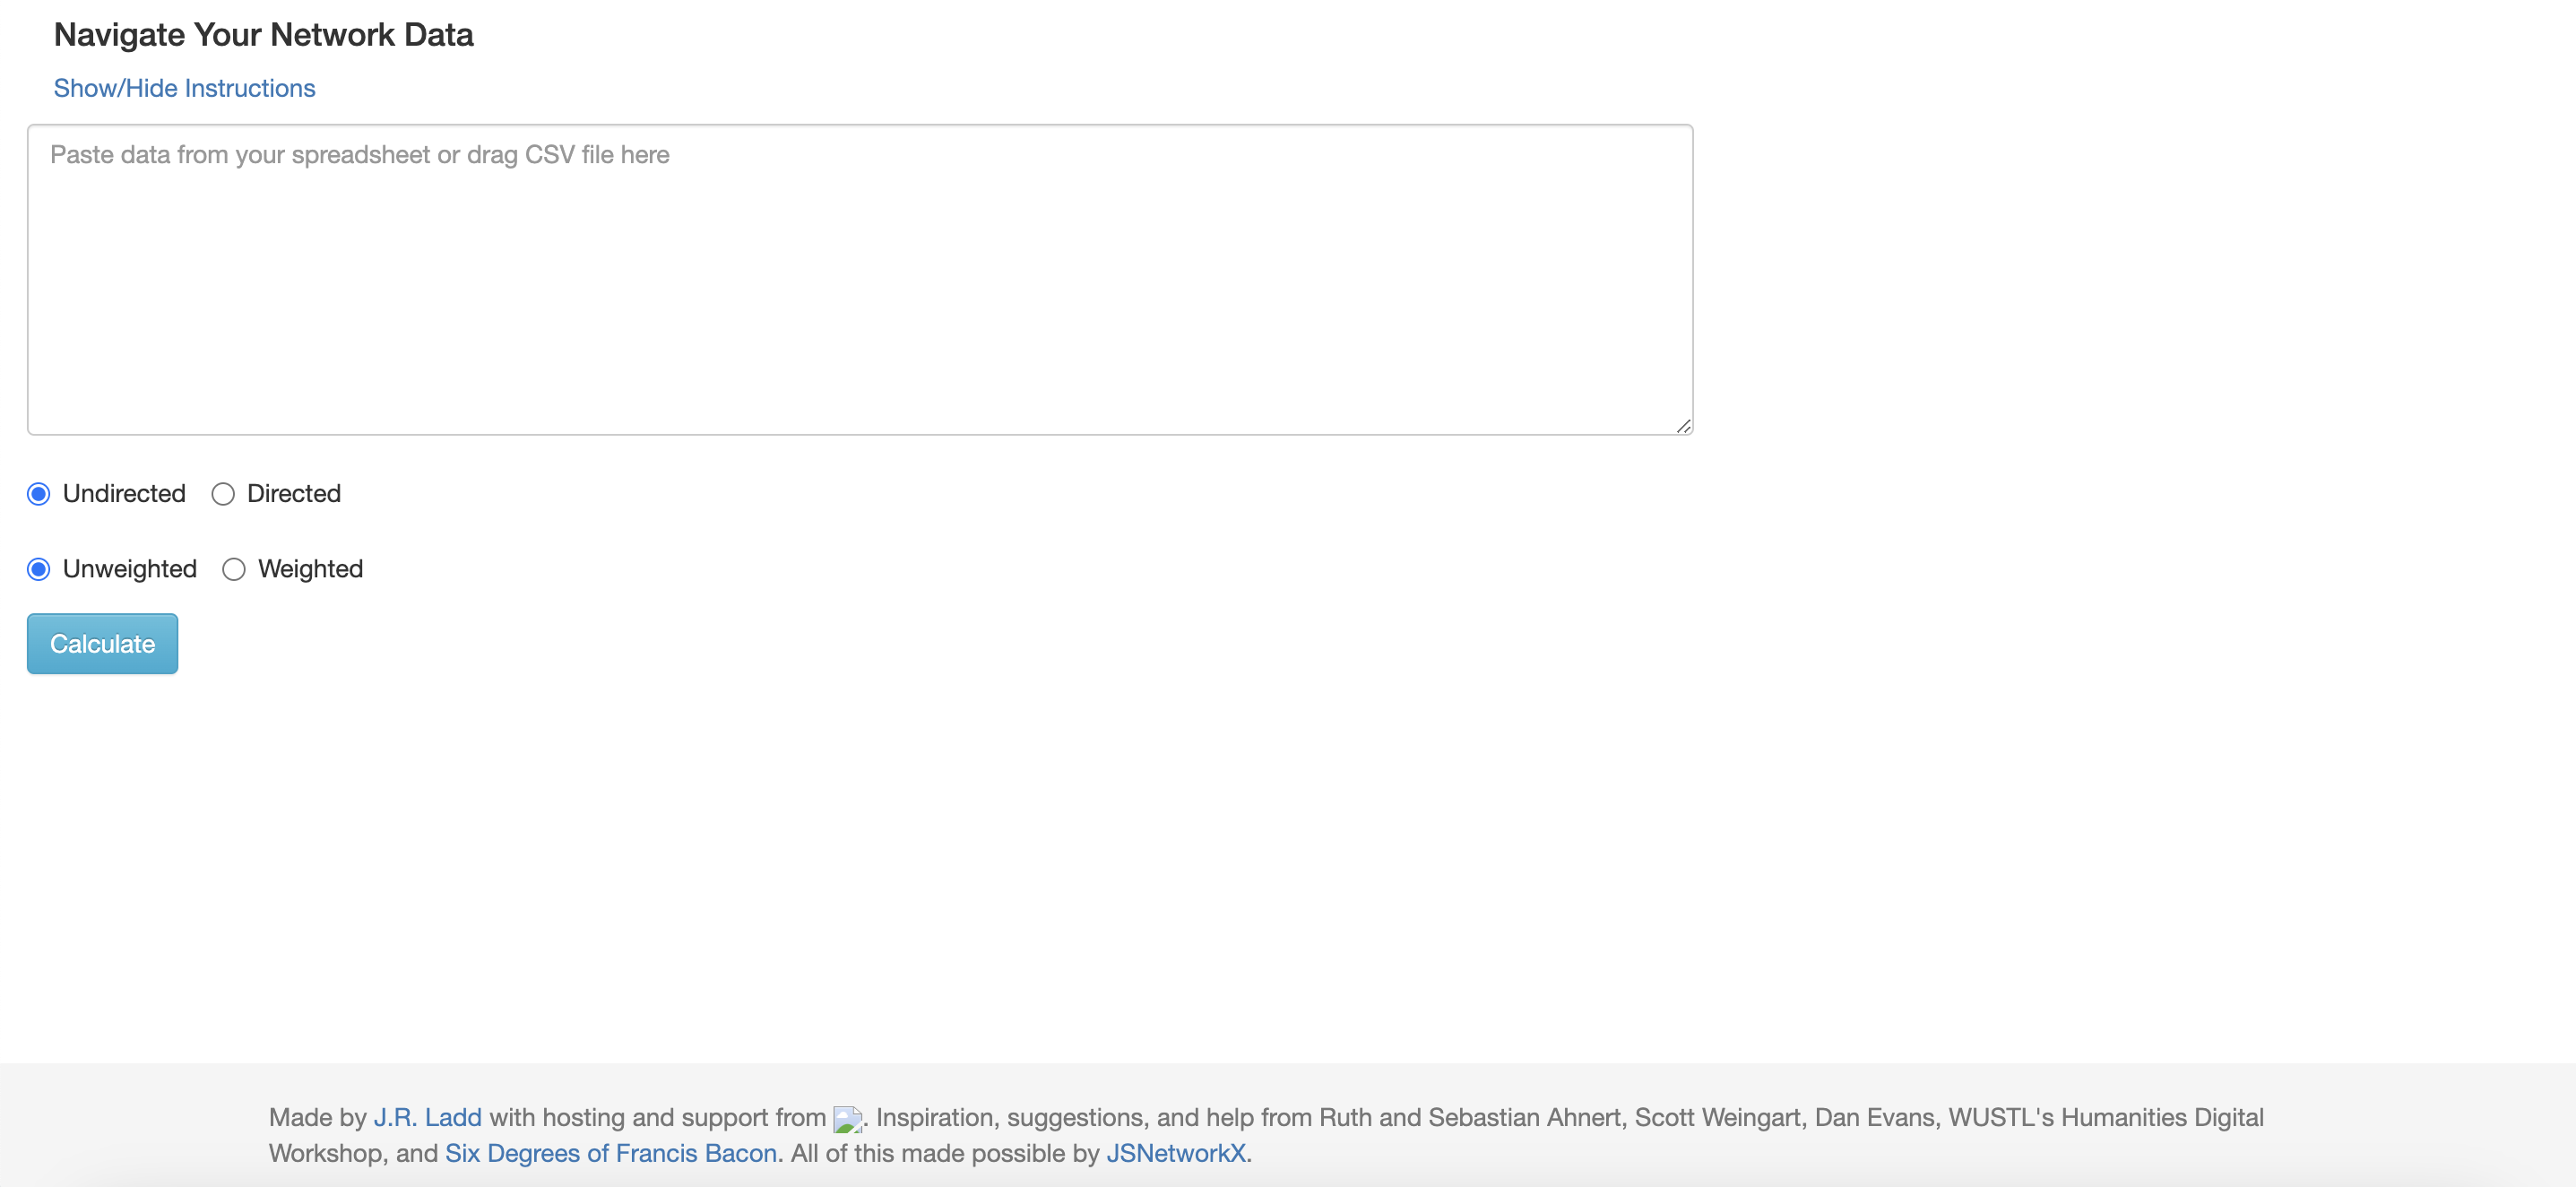

In [22]:
from IPython.display import Image 
metadata={
    "jdh": {
        "module": "object",
        "object": {
            "type":"image",
            "source": [
                "Original homepage of Network Navigator. Screenshot from https://web.archive.org/web/20190812053719/dh-web.hss.cmu.edu/network_navigator/"
            ]
        }
    }
}
display(Image("media/nn_original_homepage.png"), metadata=metadata)

Initially, *Network Navigator*  was simply a table. The imagined user would drag-and-drop network data into the browser and receive in return cleanly-formatted tabular data, detailing some standard network metrics. 

In [ ]:
from IPython.display import Image 
metadata={
    "jdh": {
        "module": "object",
        "object": {
            "type":"image",
            "source": [
                "Original files in the Network Navigator GitHub Repository. First commit on August 8, 2017. Screenshot from https://github.com/jrladd/network_navigator/tree/10ad7fd45831980980d26bdacc2913a2fb1fb23c"
            ]
        }
    }
}
display(Image("media/nn_first_commit_repo.png"), metadata=metadata)

Ladd first created the GitHub repository for *Network Navigator* on August 8, 2017, and his first commit consisted of six files: a homepage through an index HTML file, an initial Javascript file to build networks, an example spreadsheet, and then imports from two libraries: JSNetworkx for the network analysis and the web design framework Bootstrap for styling of the website. The idea for the tool was born from Ladd’s contributions to the *Six Degrees of Francis Bacon* (SDFB) project, which visualized the social networks of early modern England in a crowdsourced web application. The SDFB site included many D3 visualizations for networks, drawing on a range of then-new visualization paradigms for networks in the humanities. However, the scope of that project and its design didn’t allow for some of the more advanced metrics Ladd was using internally for the project at the time, and he saw the possibilities for a web tool that could provide this functionality. Drawing from these experiences, Ladd built the first prototype of *Network Navigator* over the remainder of 2017, and while initially hosted via Ladd’s website and GitHub pages, in 2018, with assistance from Dan Evans, the tool was hosted by Carnegie Mellon University Libraries’ servers. 

Evans was succeeded in his role by Matt Lincoln, who contributed some fixes and oversaw the site while it was hosted at CMU, which is reflected in our earlier project history visualizations.

Beyond his experience on SDFB, one of the initial motivating factors for Ladd in creating *Network Navigator* was the desire to foreground network metrics, in response to humanists’ increasing interest in networks. This shift was also due to the emergence of Cultural Analytics and data science, where researchers were exploring the potential for networks not just as visualizations or databases but also applying network statistics and graph theory to study culture. At the time, only *Gephi* had these types of metrics–*Palladio* and other network analysis tools had none–and the metrics in *Gephi* were presented in a way that was often overwhelming, if not potentially dangerous, to novices. With a few clicks, users in *Gephi* could generate an enormous amount of statistical inferences about their networks, but these buttons included few explanations of how to interpret or understand these metrics. While scholars like Ben Schmidt have argued that humanists do not need to necessarily understand these algorithms, Ladd felt that similar to Rebecca Koeser’s assessment on the dangers of trusting others to do the math, tools like *Gephi* unintentionally made it difficult for humanists to understand the principles of network analysis, at times resulting in an over-interpretation of the visual features of graph layouts rather than engagement with network statistics (<cite data-cite="14009734/IGWQ4G4A"></cite>,<cite data-cite="14009734/F4CEZB5A"></cite>). Therefore, *Network Navigator* initially combined a handful of the most popular introductory metrics in an interface that would help users learn how these metrics could inform their research questions, with the goal of helping the field move beyond networks as only a critical visualization practice towards what networks could tell us statistically and computationally. 

This core ethos has remained central to Network Navigator even as it was rebuilt by Ladd and LeBlanc, but before detailing their process, it is crucial to situate the tool within the longer history of DH tools and what Leigh Star and Karen Ruhleder termed an “ecology of infrastructure” (<cite data-cite="14009734/WTEEPNWM"></cite>). Infrastructure, though a vast and sometimes nebulous concept—as anthropologist Brian Larkin notes, it can be “conceptually unruly”—is pivotal in understanding that digital tools transcend mere outputs (<cite data-cite="14009734/B5F8YD4W"></cite>, 329). Such an approach to studying these tools is in line with the recent rise of Critical Infrastructure Studies in DH, which seeks to bridge fields like Science and Technology Studies (STS) and Library and Information Sciences (LIS) with how we study the underlying systems and structures that support and shape DH research, tools, and methodologies. How Network Navigator constitutes infrastructure then is partially a question of its relation to both users and other existing network tools, which we explore later in this article. But it is also a helpful framework to contextualize the choices that shaped this tool within the longer trends and debates over DH tools, as Yrjö Engeström has argued, when studying a tool, we need to ask “when is a tool”, rather than what is a tool”: in essence, not only exploring its functionality, but also its histories (<cite data-cite="14009734/CF4Y7LDL"></cite>). 

To help understand the growing interest in DH tools and infrastructure, we can also explore these terms in DH academic writing. This approach is far from perfect, but can offer a helpful additional line of evidence to scholarly analysis for how these terms and the ideas they represent have evolved in DH. Using DH journals and other academic writings is an increasingly popular approach to study trends in the field, such as studies of the term theory in DH journals (<cite data-cite="14009734/KXLE6DED"></cite>) or using DH journal articles to situate it across disciplines (<cite data-cite="14009734/C9WX777B"></cite>).

To do this, we use the DH Conference Abstracts dataset from the *Index of DH Conferences*, the articles in *Digital Humanities Quarterly*, as well as data from DH journals that are available in the JSTOR Constellate platform, specifically *Computers and the Humanities* and *Languague Resources and Evaluation*. The choice of these journals is partially driven by what's available, but is also informed by growing research into which journals most represent DH (<cite data-cite="14009734/CHCRP8EM"></cite>,<cite data-cite="14009734/MCSISMHQ"></cite>) .

First, we define a list of terms related to tools and infrastructure, and then we use the same functions we used earlier to identify these terms in the datasets.

In [24]:
terms = ['tool', 'tools', 'infrastructure']
tool_infrastructure_chart_output_path = f"{article_chart_directory_path}tool_infrastructure_chart.json"
rerun_chart_code = False # Set to True to rerun the code to generate the charts

We also define new functions for processing JSTOR data. To collect this data, we selected the full run of the journals and downloaded the metadata, as well as unigram, bigram, and trigram data. Because of the size of this dataset (approximately ~400 MB) we cannot include it in this repository, but it is available on request. Instead, we have preprocessed this data and save it as a csv file, which we can load in here.

In [25]:
def process_jstor_data(df: pd.DataFrame, terms: List[str], date_column: str, id_column: str, origin_column: str, word_count_column: str, joined_term: Optional[str] = None) -> pd.DataFrame:
    """
    Process and group a DataFrame to calculate term frequencies.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    terms (List[str]): A list of terms for which to calculate frequencies.
    date_column (str): The name of the column in df that contains the date.
    id_column (str): The name of the column in df that contains the ID.
    origin_column (str): The name of the column in df that contains the origin of the data.
    word_count_column (str): The name of the column in df that contains the word count.
    joined_term (str, optional): A term that we've searched for in multiple formats that we want to normalize into one term. Defaults to None.

    Returns:
    final_grouped_df (pd.DataFrame): A DataFrame containing the terms and their frequencies, grouped by date and origin.
    """
    def process_counts(row):
        for term in terms:
            split_term = term.split()
            column_length = 'unigramCount' if len(split_term) == 1 else 'bigramCount' if len(split_term) == 2 else 'trigramCount'
            counts = row[column_length][term] if term in row[column_length] else 0
            row[term] = counts
        return row

    df = df.apply(process_counts, axis=1)

    subset_df = df[[date_column, id_column, origin_column, word_count_column] + terms]
    # If a tool column is provided, create the 'finalized_tool' column
    if joined_term:
        plural_joined_term = joined_term + "s"
        subset_df[f'finalized_{joined_term}'] = np.where(subset_df[joined_term].notnull(), subset_df[joined_term], subset_df[plural_joined_term])
        subset_df = subset_df.drop(columns=[joined_term, plural_joined_term])
        subset_df = subset_df.rename(columns={f"finalized_{joined_term}": joined_term})
    melted_df = pd.melt(subset_df, id_vars=[date_column, id_column, origin_column, word_count_column], var_name='terms', value_name='counts')
    melted_df['scaled_counts'] = melted_df['counts'] / melted_df[word_count_column]
    total_df = melted_df.groupby([origin_column, date_column])[word_count_column].sum().reset_index().rename(columns={word_count_column: 'total_tokens'})
    grouped_df = melted_df.groupby([origin_column, date_column, 'terms']).counts.sum().reset_index()
    scaled_grouped_df = melted_df.groupby([origin_column, date_column, 'terms']).scaled_counts.sum().reset_index()
    final_grouped_df = pd.merge(grouped_df, scaled_grouped_df, on=[origin_column, date_column, 'terms'])
    final_grouped_df = pd.merge(final_grouped_df, total_df, on=[origin_column, date_column])
    final_grouped_df.scaled_counts = final_grouped_df.scaled_counts * 100
    final_grouped_df = final_grouped_df.rename(columns={origin_column: 'data_origin', date_column: 'date'})
    final_grouped_df["title"] = final_grouped_df.data_origin

    return final_grouped_df

In [26]:
# Check if the chart file exists
if os.path.exists(tool_infrastructure_chart_output_path) and rerun_chart_code == False:
    # Load the chart from the JSON file
    with open(tool_infrastructure_chart_output_path) as json_file:
        infrastructure_tool_chart_dict = json.load(json_file)
    infrastructure_tool_chart = alt.Chart.from_dict(infrastructure_tool_chart_dict)
else:

    # Process the DataFrame to calculate term frequencies and tokenize text
    grouped_term_index_conferences_df = process_data(
        file_path=f"{article_data_directory_path}/weingart_et_al_data/dh_conferences_works.csv",
        text_column="full_text",
        date_column="conference_year",
        terms_list=terms,
        data_origin="Index of DH Conferences",
        title="Index of DH Conferences by Weingart et al (2023)",
        term_type="terms",
        term_mapping=False,
        joined_term="tool"
    )

    # Process the DataFrame to calculate term frequencies and tokenize text
    grouped_term_dhq_df = process_data(
        file_path=f"{article_data_directory_path}/scraped_dhq_data/dhq_articles.csv",
        text_column="body_text",
        date_column="date_processed",
        terms_list=terms,
        data_origin="DHQ",
        title="DHQ Articles (2023)",
        term_type="terms",
        term_mapping=False,
        joined_term="tool"
    )
    if os.path.exists(f"{article_data_directory_path}constellate_data/jstor_data_infrastructure_tool.csv") == False:
        jstor_data = pd.read_json(f"{article_data_directory_path}constellate_data/private_data/jstor_data-jsonl.jsonl", lines=True)
        jstor_data['datePublished'] = pd.to_datetime(jstor_data['datePublished'])
        grouped_jstor_data = process_jstor_data(jstor_data, terms, 'datePublished', 'id', 'isPartOf', 'wordCount', joined_term='tool')
    else:
        grouped_jstor_data = pd.read_csv(f"{article_data_directory_path}constellate_data/jstor_data_infrastructure_tool.csv")

    term_combined_df = pd.concat([grouped_term_index_conferences_df, grouped_term_dhq_df, grouped_jstor_data])
    term_combined_df = term_combined_df.reset_index(drop=True)
    term_combined_df = term_combined_df.rename(columns={"counts": "Raw Frequency of Mentions", "scaled_counts": "Frequency of Mentions Scaled by Total Tokens"})

    term_combined_df.date = term_combined_df.date.astype(str)
    term_combined_df.date = term_combined_df.date.str.split(" ").str[0]
    term_combined_df['date'] = pd.to_datetime(term_combined_df.date, format='%Y-%m-%d')


    dropdown = alt.binding_select(
        options=['Raw Frequency of Mentions', 'Frequency of Mentions Scaled by Total Tokens'], 
        name='Select Counting Method on Y Axis'
    )
    ycol_param = alt.param(
        value="Raw Frequency of Mentions",
        bind=dropdown
    )

    infrastructure_term = term_combined_df[term_combined_df.terms == 'infrastructure']
    selection = alt.selection_point(fields=['data_origin'], bind='legend')
    infrastructure_chart = alt.Chart(infrastructure_term).mark_bar().encode(
        x=alt.X('year(date):T', axis=alt.Axis(title="Year")),
        y=alt.Y('y:Q', axis=alt.Axis(title="Frequency of Mentions")),
        color=alt.Color('data_origin:N', legend=alt.Legend(title="Data Origin", symbolLimit=0, labelLimit=0), scale=alt.Scale( scheme='tableau20'), sort=alt.EncodingSortField(field="counts", op="sum", order='descending')),
        tooltip=[
            alt.Tooltip('data_origin', title='Data Origin'),
            alt.Tooltip('Raw Frequency of Mentions'),
            alt.Tooltip('date:T', title='Date', format='%Y'),
            alt.Tooltip('Frequency of Mentions Scaled by Total Tokens', title="Frequency of Mentions Scaled by Total Tokens (Percentage)", format='.2f'),
            alt.Tooltip('total_tokens', title='Total Tokens'),
        ],
        opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
    ).transform_calculate(
        y=f'datum[{ycol_param.name}]'
    ).add_params(
        ycol_param, selection
    ).properties(
        title="Popularity of the Term 'Infrastructure' Over Time and Across Multiple Datasets",
        width=500
    )

    tool_term = term_combined_df[term_combined_df.terms == 'tool']

    selection = alt.selection_point(fields=['data_origin'], bind='legend')

    tool_chart = alt.Chart(tool_term).mark_bar().encode(
        x=alt.X('year(date):T', axis=alt.Axis(title="Year")),
        y=alt.Y('y:Q', axis=alt.Axis(title="Frequency of Mentions")),
        color=alt.Color('data_origin:N', legend=alt.Legend(title="Data Origin", symbolLimit=0, labelLimit=0), scale=alt.Scale( scheme='tableau20'), sort=alt.EncodingSortField(field="counts", op="sum", order='descending')),
        tooltip=[
            alt.Tooltip('data_origin', title='Data Origin'),
            alt.Tooltip('Raw Frequency of Mentions'),
            alt.Tooltip('date:T', title='Date', format='%Y'),
            alt.Tooltip('Frequency of Mentions Scaled by Total Tokens', title="Frequency of Mentions Scaled by Total Tokens (Percentage)", format='.2f'),
            alt.Tooltip('total_tokens', title='Total Tokens'),
        ],
        opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
    ).transform_calculate(
        y=f'datum[{ycol_param.name}]'
    ).add_params(
        ycol_param, selection
    ).properties(
        title=f"Popularity of the Term 'Tool' Over Time and Across Multiple Datasets",
        width=500
    )

    infrastructure_tool_chart = alt.vconcat(infrastructure_chart, tool_chart).configure(
        title=alt.TitleConfig(fontSize=20, font='Garamond', anchor='middle'),
        axis=alt.AxisConfig(labelFont='Garamond', titleFont='Garamond'),
        legend=alt.LegendConfig(labelFont='Garamond', titleFont='Garamond')
    )
    infrastructure_tool_chart.save(tool_infrastructure_chart_output_path)        

In [27]:
infrastructure_tool_chart

alt.VConcatChart(...)

These charts show that whether using raw frequencies or scaling by length of articles over time, both tools and infrastructure have become increasingly popular in DH. You can also select each publication in the legend to see these trends more clearly. 

While this is not surprising, it does suggest that these terms are worth further investigation, especially since they are often used in DH without being defined or even interrogated. Indeed, while tool has been present from the outset of DH writing (though increasingly prevalent since 2005), infrastructure seems to be a more recent discourse, only emerging around 2000 and then becoming very popular; a finding we hope to explore more in-depth in the future.

While histories of DH have started to proliferate in the last two decades, there remain few that foreground individual tools or methodologies, though certainly scholars like Julia Nyhan and Melissa Terras have recovered parts of this history, whether through complicating our histories of Robert Busa’s concordance programs or tracing the careers of the first DH developers, like John Bradley who started developing tools for text analysis in the 1970s (<cite data-cite="14009734/IVAWRTNG"></cite>,<cite data-cite="14009734/WJCHZWBW"></cite>). If we primarily focus then on tools, unsurprisingly we find that the advent of mass digitization and the web in the 1990s and early 2000s was a moment of intense debate over tools (as indicated in our visualizations). Indeed, in 2003, John Unsworth, reflecting on the last decade of humanities computing, questioned whether the field was “going around in circles” because of the consistent refrain for needing better tools for humanities research (<cite data-cite="14009734/DVU3K8KC"></cite>). To overcome these obstacles, Unsworth proposed the framing of ‘scholarly primitives’ to elucidate the theoretical and shared functions that undergird humanities research “that could be the basis for a manageable but also useful tool-building enterprise in humanities computing.” Part of Unsworth’s primitives was trying to envision the potential of DH tools, but it was also intended to argue for the necessity of these tools: both to grant funders and especially to skeptical humanists (<cite data-cite="14009734/BNUZH96S"></cite>). Such a focus was also central to the 2006 Summit on Digital Tools for the Humanities, also chaired by Unsworth, which argued “that only about six percent of humanist scholars go beyond general purpose information technology and use digital resources and more complex digital tools in their scholarship” (<cite data-cite="14009734/8DC6SYTG"></cite>). This claim was further supported by Patrick Juola, who through citation analysis showed that very few high profile humanists had published or even engaged with humanities computing, though journals like *Computers and the Humanities* had been in print since the 1960s. This lack of engagement, especially given the growing abundance of born digital and digitized materials, led many to conclude that most DH tools were too bespoke for the average humanist, and that the solution was to focus on creating shared, large-scale infrastructure, or what Juola termed a “Killer App” (<cite data-cite="14009734/EFPWW7BX"></cite>). Realizing this dream of wide-spread uptake of DH tools was also often tied to calls for standardizing tool infrastructures that was partially realized in projects like TEI and the maturing of web technologies (<cite data-cite="14009734/62M584MJ"></cite>). But even without these shared standards or killer apps, this sense that large scale software development as the solution was undoubtedly influential in the development of tools like *Zotero* and *Voyant Tools*, along with network analysis tools like *Gephi*, whose developers described being “inspired by WYSIWYG editors like Adobe Photoshop” (<cite data-cite="14009734/ZU6QXVNL"></cite>, 361).

However, *Gephi* itself was not initially conceived of or built as primarily a tool for digital humanities research. According to Clément Levallois, the idea for *Gephi* was first developed in 2006 by Mathieu Jacomy, as part of his work with the e-Diasporas Atlas project and, and by Eytan Adar, as part of his work on GUESS, the Graph Exploration System Software (<cite data-cite="14009734/K5C75JVX"></cite>). Together with researchers from Université Technologique de Compiègne, the team worked on developing the initial version of *Gephi*, releasing it for download on September 8, 2008, and then making the software public on GitHub on March 2, 2009. Part of the impetus for *Gephi*, according to one of the developers Sebastien Heymann, was that “other network visualization software is either a poor visualization module or a stunning aspect but not efficient.” For example, one of the earliest network analysis tools, Pajek, first released in 1997, would only let you visualize a few hundred nodes, and GUESS, released in 2007, could only display up to 2000 nodes. Thus, the creators of *Gephi* initially focused on leveraging new graphical technologies like GPUs to render much larger networks; the initial release could do up to 50000 nodes (<cite data-cite="14009734/DGNAHYY3"></cite>). But the very existence of this software was also indicative of the massive growth of network science as a field during this period. As the authors of The Network Turn have argued, the 1998 publication “Collective Dynamics of Small World Networks” by Duncan J. Watts and Steven Strogatz and the 1999 publication “Emergence of Scaling in Random Networks” by Albert-László Barabási and Réka Albert “ushered in the field of network science,” in many ways parallel to the coterminous growth of digital humanities (<cite data-cite="14009734/6G36YAJC"></cite>, 21). And yet, much of this initial debate over DH tools was focused almost exclusively on tools for working with digitized texts (whether editing and annotating or analyzing them). 

To see more on the history of *Gephi*, we also explored the early commit history https://github.com/gephi/gephi/commit/c1a1b8316427b1e5c6e0ea5ea8031a016b7ba2c1 and web archived versions of their website https://web.archive.org/web/20080912001706/https://gephi.org/ .

We can also get a sense of this transformation through exploring the rise of networks and network analysis in DH writing, using our same methods as before.

In [28]:
terms = ['network', 'networks', 'network analysis']
network_analysis_chart_output_path = f"{article_chart_directory_path}network_analysis_chart.json"
rerun_chart_code = False # Set to True to rerun the code to generate the charts

In [29]:
# Check if the chart file exists
if os.path.exists(network_analysis_chart_output_path) and rerun_chart_code == False:
    # Load the chart from the JSON file
    with open(network_analysis_chart_output_path) as json_file:
        network_analysis_chart_dict = json.load(json_file)
    network_analysis_chart = alt.Chart.from_dict(network_analysis_chart_dict)
else:

    # Process the DataFrame to calculate term frequencies and tokenize text
    grouped_term_index_conferences_df = process_data(
        file_path=f"{article_data_directory_path}/weingart_et_al_data/dh_conferences_works.csv",
        text_column="full_text",
        date_column="conference_year",
        terms_list=terms,
        data_origin="Index of DH Conferences",
        title="Index of DH Conferences by Weingart et al (2023)",
        term_type="terms",
        term_mapping=False,
        joined_term="network"
    )

    # Process the DataFrame to calculate term frequencies and tokenize text
    grouped_term_dhq_df = process_data(
        file_path=f"{article_data_directory_path}scraped_dhq_data/dhq_articles.csv",
        text_column="body_text",
        date_column="date_processed",
        terms_list=terms,
        data_origin="DHQ",
        title="DHQ Articles (2023)",
        term_type="terms",
        term_mapping=False,
        joined_term="network"
    )

    if os.path.exists(f"{article_data_directory_path}constellate_data/jstor_data_network_analysis.csv") == False:
        jstor_data = pd.read_json(f"{article_data_directory_path}constellate_data/jstor_data-jsonl.jsonl", lines=True)
        jstor_data['datePublished'] = pd.to_datetime(jstor_data['datePublished'])
        grouped_jstor_data = process_jstor_data(jstor_data, terms, 'datePublished', 'id', 'isPartOf', 'wordCount', joined_term='network')
    else:
        grouped_jstor_data = pd.read_csv(f"{article_data_directory_path}constellate_data/jstor_data_network_analysis.csv")

    term_combined_df = pd.concat([grouped_term_index_conferences_df, grouped_term_dhq_df, grouped_jstor_data])
    term_combined_df = term_combined_df.reset_index(drop=True)
    term_combined_df = term_combined_df.rename(columns={"counts": "Raw Frequency of Mentions", "scaled_counts": "Frequency of Mentions Scaled by Total Tokens"})

    term_combined_df.date = term_combined_df.date.astype(str)
    term_combined_df.date = term_combined_df.date.str.split(" ").str[0]
    term_combined_df['date'] = pd.to_datetime(term_combined_df.date, format='%Y-%m-%d')


    dropdown = alt.binding_select(
        options=['Raw Frequency of Mentions', 'Frequency of Mentions Scaled by Total Tokens'], 
        name='Select Counting Method on Y Axis'
    )
    ycol_param = alt.param(
        value="Raw Frequency of Mentions",
        bind=dropdown
    )

    network_term = term_combined_df[term_combined_df.terms == 'network']
    selection = alt.selection_point(fields=['data_origin'], bind='legend')
    network_chart = alt.Chart(network_term).mark_bar().encode(
        x=alt.X('year(date):T', axis=alt.Axis(title="Year")),
        y=alt.Y('y:Q', axis=alt.Axis(title="Frequency of Mentions")),
        color=alt.Color('data_origin:N', legend=alt.Legend(title="Data Origin", symbolLimit=0, labelLimit=0), scale=alt.Scale( scheme='tableau20'), sort=alt.EncodingSortField(field="counts", op="sum", order='descending')),
        tooltip=[
            alt.Tooltip('data_origin', title='Data Origin'),
            alt.Tooltip('Raw Frequency of Mentions'),
            alt.Tooltip('date:T', title='Date', format='%Y'),
            alt.Tooltip('Frequency of Mentions Scaled by Total Tokens', title="Frequency of Mentions Scaled by Total Tokens (Percentage)", format='.2f'),
            alt.Tooltip('total_tokens', title='Total Tokens'),
        ],
        opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
    ).transform_calculate(
        y=f'datum[{ycol_param.name}]'
    ).add_params(
        ycol_param, selection
    ).properties(
        title="Popularity of the Term 'Network' Over Time and Across Multiple Datasets",
        width=500
    )

    network_analysis_term = term_combined_df[term_combined_df.terms == 'network analysis']

    selection = alt.selection_point(fields=['data_origin'], bind='legend')

    network_analysis_chart = alt.Chart(network_analysis_term).mark_bar().encode(
        x=alt.X('year(date):T', axis=alt.Axis(title="Year")),
        y=alt.Y('y:Q', axis=alt.Axis(title="Frequency of Mentions")),
        color=alt.Color('data_origin:N', legend=alt.Legend(title="Data Origin", symbolLimit=0, labelLimit=0), scale=alt.Scale( scheme='tableau20'), sort=alt.EncodingSortField(field="counts", op="sum", order='descending')),
        tooltip=[
            alt.Tooltip('data_origin', title='Data Origin'),
            alt.Tooltip('Raw Frequency of Mentions'),
            alt.Tooltip('date:T', title='Date', format='%Y'),
            alt.Tooltip('Frequency of Mentions Scaled by Total Tokens', title="Frequency of Mentions Scaled by Total Tokens (Percentage)", format='.2f'),
            alt.Tooltip('total_tokens', title='Total Tokens'),
        ],
        opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
    ).transform_calculate(
        y=f'datum[{ycol_param.name}]'
    ).add_params(
        ycol_param, selection
    ).properties(
        title=f"Popularity of the Term 'Network Analysis' Over Time and Across Multiple Datasets",
        width=500
    )

    network_analysis_chart = alt.vconcat(network_chart, network_analysis_chart).configure(
        title=alt.TitleConfig(fontSize=20, font='Garamond', anchor='middle'),
        axis=alt.AxisConfig(labelFont='Garamond', titleFont='Garamond'),
        legend=alt.LegendConfig(labelFont='Garamond', titleFont='Garamond')
    )
    network_analysis_chart.save(network_analysis_chart_output_path)

In [30]:
network_analysis_chart

alt.VConcatChart(...)

Similar to our graph above, these charts visualize how networks and network analysis have increasingly become popular in DH, even when scaled by the length of articles. You can also select each publication in the legend to see these trends more clearly.

Also of note is that while networks, like tools, have been present in DH writing since the beginning, network analysis is a more recent phenomenon, only emerging in the mid-2000s and then becoming increasingly popular. This trend seems to correspond with the growing popularity of network analysis tools, like *Gephi*, which we explored in the introduction.

Since then, tools for network analysis, like *Gephi*, have become very popular in the field. But we believe that part of this shift is not only the availability of these tools, but also the shift in how DH as a field approaches these tools, both in terms of making and theorizing them, and that understanding these shifts is critical for contextualizing *Network Navigator*.

To understand the growth then of network analysis tools, we need to return to the aftermath of the 2006 Summit on DH Tools, where one of the main takeaways was that these digital tools needed further theorizing to uncover why they were not being more widely adopted or why more were not being built in the first place. To that end, Susan Schreibman and Ann Hanlon completed the first survey of DH tool developers in 2008 to understand how the creators of these tools conceived of their efforts. While the survey focused on a mix of “branded” and “unbranded” DH tools, the main finding was that “overwhelming majority of respondents (94%) considered tool development a scholarly activity, although the range of responses to this question made it clear that many departments and institutions do not” (<cite data-cite="14009734/GWRSYWVR"></cite>). Part of the solution to this disconnect was increased advocacy on evaluating and crediting digital scholarship through scholarly associations like the MLA and AHA, but there was also a growing debate over whether tools should be considered not just scholarship, but also as theoretical objects into themselves.

For DH developers like John Bradley, there was a sense that “in early discussions on the Humanist discussion list (for example in the late 1980s and early 1990s), the term ‘tool’ often carried a pejorative tone, with the implication of considering something as ‘merely a tool’” (<cite data-cite="14009734/VSVHNBCB"></cite>, 153-154). But the proliferation of new digital tools led scholars like Willard McCarty in a Humanist exchange to question whether “digital artifacts” could be interpreted without some paratextual explanation: in essence, could digital tools function as other forms of scholarly objects or were they simply a means to an end. Stephen Ramsay and Geoffrey Rockwell sought to directly answer this question, arguing that if building functioned similarly to writing technologies, then “the quality of the interventions that occur as a result of building are as interesting as those that are typically established through writing, then that activity is, for all intents and purposes, scholarship” (<cite data-cite="14009734/NPX9J9CR"></cite>, 83). Ramsay had proposed a similar assessment earlier in 2011 at the MLA arguing for building and making as “a new kind of hermeneutic,” though his assertion became somewhat overshadowed by his framing of defining who ‘counted’ as a digital humanist (<cite data-cite="14009734/NX4XN5JL"></cite>). But even before what eventually became the “hack versus yack” debates, there was growing awareness but also anxiety over digital tools, as Julia Flanders articulated, “Digital tools add a challenge and give us a new set of terms — like a new planet in the system, they change the vectors of all the other things we have in our universe. They will probably change the way humanities research is done” (<cite data-cite="14009734/U5S5QBGA"></cite>).

Assessing this “new planet” of digital tools then would require not only new forms of credit for creating tools, but also the development of new scholarly infrastructure and frameworks that centered tools as objects of study. Part of this transformation was evidenced in growing calls for peer review of these tools. Initially advocated by Alan Galey and Stan Ruecker who, building from Lev Manovich’s response to McCarthy that “a prototype is a theory”, proposed that prototypes should be peer reviewed like other forms of scholarship. For Galey and Ruecker, prototypes were a capacious category that included tools, along with many ‘digital objects.’ But regardless of terminology, the authors argued that peer reviewing would serve as a “useful bridge between the tool-building tradition of the digital humanities on one hand, and interpretive and critical traditions like book history and science and technology studies on the other,” helping move tools from being seen as service-based outputs towards inquiry-based ones (<cite data-cite="14009734/R3YCV5WX"></cite>, 406). The necessity of such peer review mechanisms was further reinforced by Annie Swafford with her analysis of Matthew Jockers’ sentiment analysis library “Syuzhet,” which eventually became the subject of a protracted Twitter debate over the assumptions built into the tool, something Swafford felt that formal peer review would have been better suited to resolving. To avoid future Syuzhet debates and to realize Galey and Ruecker’s vision, many academic journals have increasingly developed mechanisms for reviewing digital projects and even tools (<cite data-cite="14009734/KGFN5ATC"></cite>). But even more profound has been the development of more robust theoretical frameworks for analyzing tools that not only detail the functionalities of these tools, but also explore the socio-political assumptions built into these tools.

The most prominent framework to this end has been the concept of “tool criticism”, which was inspired by earlier work on digital source criticism and algorithmic criticism, as well as the emergence of Critical Code Studies and Software Studies both of which treat code as an object for scholarship. As far as we have been able to determine, the first call for this type of work was in a Master’s thesis by Anastasia Dorofeeva titled “Towards Digital Humanities Tool Criticism” published in 2014 from the University of Leiden (<cite data-cite="14009734/6HWILXZU"></cite>). Since then, the concept has quickly become popular as a methodology that reflexively attends to both the technical and socio-political nature of DH tools (<cite data-cite="14009734/IWJ5QTS3"></cite>,<cite data-cite="14009734/2J8EMTJM"></cite>). In defining this approach, Karin Van Es, Maranke Wieringa, and Mirko Tobias Schäfer argue that it not only embodies a critical approach to computation, like the ones advocated by CCS scholars like David M. Berry, but also “incorporates reflection on the interaction between the researcher and the tool” and at the same time collapses “distinction of tool builder and researcher” (<cite data-cite="14009734/32WND4AE"></cite>, 26).

To explore the emergence of these theoretical approaches to both computational methods and tools, we can once again turn to DH writing, using our same methods as before.

In [32]:
terms = ['tool criticism', 'algorithmic criticism']
tool_algo_criticism_chart_output_path = f"{article_chart_directory_path}tool_algo_criticism_chart.json"
rerun_chart_code = False # Set to True to rerun the code to generate the charts

In [33]:
# Check if the chart file exists
if os.path.exists(tool_algo_criticism_chart_output_path) and rerun_chart_code == False:
    # Load the chart from the JSON file
    with open(tool_algo_criticism_chart_output_path) as json_file:
        tool_algo_criticism_chart_dict = json.load(json_file)
    tool_algo_criticism_chart = alt.Chart.from_dict(tool_algo_criticism_chart_dict)
else:

    # Process the DataFrame to calculate term frequencies and tokenize text
    grouped_term_index_conferences_df = process_data(
        file_path=f"{article_data_directory_path}weingart_et_al_data/dh_conferences_works.csv",
        text_column="full_text",
        date_column="conference_year",
        terms_list=terms,
        data_origin="Index of DH Conferences",
        title="Index of DH Conferences by Weingart et al (2023)",
        term_type="terms",
        term_mapping=False,
        joined_term=None
    )

    # Process the DataFrame to calculate term frequencies and tokenize text
    grouped_term_dhq_df = process_data(
        file_path=f"{article_data_directory_path}scraped_dhq_data/dhq_articles.csv",
        text_column="body_text",
        date_column="date_processed",
        terms_list=terms,
        data_origin="DHQ",
        title="DHQ Articles (2023)",
        term_type="terms",
        term_mapping=False,
        joined_term=None
    )

    if os.path.exists(f"{article_data_directory_path}constellate_data/jstor_data_tool_algorithmic_criticism.csv") == False:
        jstor_data = pd.read_json(f"{article_data_directory_path}constellate_data/jstor_data-jsonl.jsonl", lines=True)
        jstor_data['datePublished'] = pd.to_datetime(jstor_data['datePublished'])
        grouped_jstor_data = process_jstor_data(jstor_data, terms, 'datePublished', 'id', 'isPartOf', 'wordCount', joined_term=None)
    else:
        grouped_jstor_data = pd.read_csv(f"{article_data_directory_path}constellate_data/jstor_data_tool_algorithmic_criticism.csv")

    term_combined_df = pd.concat([grouped_term_index_conferences_df, grouped_term_dhq_df, grouped_jstor_data])
    term_combined_df = term_combined_df.reset_index(drop=True)
    term_combined_df = term_combined_df.rename(columns={"counts": "Raw Frequency of Mentions", "scaled_counts": "Frequency of Mentions Scaled by Total Tokens"})

    term_combined_df.date = term_combined_df.date.astype(str)
    term_combined_df.date = term_combined_df.date.str.split(" ").str[0]
    term_combined_df['date'] = pd.to_datetime(term_combined_df.date, format='%Y-%m-%d')


    dropdown = alt.binding_select(
        options=['Raw Frequency of Mentions', 'Frequency of Mentions Scaled by Total Tokens'], 
        name='Select Counting Method on Y Axis'
    )
    ycol_param = alt.param(
        value="Raw Frequency of Mentions",
        bind=dropdown
    )

    tool_criticism_term = term_combined_df[term_combined_df.terms == 'tool criticism']
    selection = alt.selection_point(fields=['data_origin'], bind='legend')
    tool_criticism_chart = alt.Chart(tool_criticism_term).mark_bar().encode(
        x=alt.X('year(date):T', axis=alt.Axis(title="Year")),
        y=alt.Y('y:Q', axis=alt.Axis(title="Frequency of Mentions")),
        color=alt.Color('data_origin:N', legend=alt.Legend(title="Data Origin", symbolLimit=0, labelLimit=0), scale=alt.Scale( scheme='tableau20'), sort=alt.EncodingSortField(field="counts", op="sum", order='descending')),
        tooltip=[
            alt.Tooltip('data_origin', title='Data Origin'),
            alt.Tooltip('Raw Frequency of Mentions'),
            alt.Tooltip('date:T', title='Date', format='%Y'),
            alt.Tooltip('Frequency of Mentions Scaled by Total Tokens', title="Frequency of Mentions Scaled by Total Tokens (Percentage)", format='.2f'),
            alt.Tooltip('total_tokens', title='Total Tokens'),
        ],
        opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
    ).transform_calculate(
        y=f'datum[{ycol_param.name}]'
    ).add_params(
        ycol_param, selection
    ).properties(
        title="Popularity of the Term 'Tool Criticism' Over Time and Across Multiple Datasets",
        width=500
    )

    algorithmic_criticism_term = term_combined_df[term_combined_df.terms == 'algorithmic criticism']

    selection = alt.selection_point(fields=['data_origin'], bind='legend')

    algorithmic_criticism_chart = alt.Chart(algorithmic_criticism_term).mark_bar().encode(
        x=alt.X('year(date):T', axis=alt.Axis(title="Year")),
        y=alt.Y('y:Q', axis=alt.Axis(title="Frequency of Mentions")),
        color=alt.Color('data_origin:N', legend=alt.Legend(title="Data Origin", symbolLimit=0, labelLimit=0), scale=alt.Scale( scheme='tableau20'), sort=alt.EncodingSortField(field="counts", op="sum", order='descending')),
        tooltip=[
            alt.Tooltip('data_origin', title='Data Origin'),
            alt.Tooltip('Raw Frequency of Mentions'),
            alt.Tooltip('date:T', title='Date', format='%Y'),
            alt.Tooltip('Frequency of Mentions Scaled by Total Tokens', title="Frequency of Mentions Scaled by Total Tokens (Percentage)", format='.2f'),
            alt.Tooltip('total_tokens', title='Total Tokens'),
        ],
        opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
    ).transform_calculate(
        y=f'datum[{ycol_param.name}]'
    ).add_params(
        ycol_param, selection
    ).properties(
        title=f"Popularity of the Term 'Algorithmic Criticism' Over Time and Across Multiple Datasets",
        width=500
    )

    tool_algo_criticism_chart = alt.vconcat(tool_criticism_chart, algorithmic_criticism_chart).configure(
        title=alt.TitleConfig(fontSize=20, font='Garamond', anchor='middle'),
        axis=alt.AxisConfig(labelFont='Garamond', titleFont='Garamond'),
        legend=alt.LegendConfig(labelFont='Garamond', titleFont='Garamond')
    )
    tool_algo_criticism_chart.save(tool_algo_criticism_chart_output_path)

In [34]:
tool_algo_criticism_chart

alt.VConcatChart(...)

Our results in these charts emphasize the relative novelty of tool and algorithmic criticism, but also the growing popularity of these terms in DH. You can also select each publication in the legend to see these trends more clearly.

In the case of *Network Navigator*, tool criticism has been particularly helpful for reflecting on our design and development choices, though we were not directly familiar with it when building *Network Navigator*. But tool criticism is also broadly relevant since many scholars have focused on *Gephi* and network analysis as a case study for this framework. For example, Van Es et al utilize tool criticism to critically theorize *Gephi*’s popularity and also elucidate its constraints, such as the ways in which the tool “gives a large audience the ability to produce network diagrams without understanding the ‘layers of mediation’ involved in its production.” To help make these layers visible, the authors detail creating the “Gephi field notes plugin,” which takes snapshots of a network in *Gephi*, along with the transformations required to create it and saves it as a text file (<cite data-cite="14009734/32WND4AE"></cite>, 25). In many ways, the creation of this plugin corresponds with our desire to create *Network Navigator*, as attempts to intervene in scholarly practices. And similarly, both our projects also build from Johanna Drucker and Patrick Svensson’s concept of “middleware.” Though the concept of middleware is somewhat more narrow than tool criticism, in a 2016 DHQ article, Drucker and Svensson argued that greater scholarly attention was needed to uncover how software (whether tools or platforms) shape scholarly arguments. The authors highlighted the example of *Gephi* diagrams, describing how the popularity of force-layout diagrams elide over how these visualizations are “not a natural expression of structured data, it is instead a distinct expression in a system authored by a programmer responsible for the coming-into-being of that visual form in a precise form” (<cite data-cite="14009734/FVU9I7DB"></cite>). More recent work has continued to theorize *Gephi* through the lens of tool criticism, including work by Daniela Van Geenen, who has published two recent articles (the second of which includes some of the lead developers of *Gephi*). In the first, she uses tool criticism, along with the framing of “epistemological affordances,” to explore how *Gephi*’s interface and documentation enables users to follow the progression of their work and scrutinize the methods applied within the tool. Of particular concern to Van Geenen is how *Gephi* limits “reversibility and reproducibility,” and she argues that the lack of undo or redo functionality undermines any algorithmic accountability or critical use of *Gephi* (<cite data-cite="14009734/2RG8L9PE"></cite>, 18-19). While we agree with Van Geenen on the importance of understanding these algorithms, building this proposed undo/redo functionality for any network algorithm would require significant computational resources, which is why we have not included such features in *Network Navigator*. Nonetheless, we believe that our tool shares a similar core ethos to this scholarship; in essence, the belief that these tools should promote a critical technical practice that goes beyond mere tool functionality and considers the diverse uses of networks across and beyond scholarly communities. Which is why in our development of *Network Navigator* we have focused primarily on DH pedagogical needs, but have also been inspired by growing critiques of large scale infrastructure for DH research.

Though both Ladd and LeBlanc had previous experience building complex web applications, as mentioned previously *Network Navigator* is largely composed of foundational web technologies: HTML, CSS, and Javascript. Such a relatively simple technological stack is in contrast to tools like *Gephi* or *Voyant Tools*, both of which are built in Java with far more complex design patterns and architecture. But while our technical choices diverge from other DH tools, we are far from the first to consider privileging less as more. As early as 2012, scholars like Joris Van Zundert were arguing that “big institutionally-based digital infrastructures are a dead end for information technology development and application in the humanities.” While Van Zundert was critiquing proposals like the ones for Killer Apps, his assessments on the difficulties, if not outright impossibility, of building widely generalizable tools for humanities research that go beyond digitization echo much of the criticisms of tools like *Gephi* and correspond with our experiences teaching these tools, all of which has informed *Network Navigator*. In particular, Van Zundert called for “super-lightweight humanities research microservices” that would have buy-in from developers and be low-cost to maintain as an alternative future for “tool building in the digital humanities [that] is still in the process of maturing” (<cite data-cite="14009734/22G7828D"></cite>, 182-184). In 2016, Dennis Tenen made a similar argument of how “big software” was increasingly unfit for the growing “computational turn” in DH and other disciplines, which with the rise of data analysis programming and coding libraries made building these tools not only somewhat unnecessary, but also ill-suited to understanding their underlying computational methodologies. Instead, Tenen argued that experimentation and iteration were critical, and that ultimately, “the best kind of tools are therefore the ones that we make ourselves” (<cite data-cite="14009734/ZUMV4AN3"></cite>). While these critiques have yet to fully percolate into how DH tools are built, let alone funded, we believe these critiques were not isolated, but rather indicative and associated with the rise of minimal computing in DH.

First proposed as part of the GO::DH working group in the mid 2010s as the “application of minimalist principles to computing”, in a recent DHQ special issue dedicated to the topic, the term has evolved to become much more expansive to the point that the editors of the issue, Roopika Risam and Alex Gil argue that “defining minimal computing is as quixotic a task as defining digital humanities itself” (much like DH tools we would argue) (<cite data-cite="14009734/K8MMJ5PG"></cite>,<cite data-cite="14009734/V75YBFMY"></cite>). But even if capacious, minimal computing has become a particularly influential framework, leading many scholars to pivot from complex web applications and databases towards simpler, more sustainable technologies like static site generators, exemplified by tools like Jekyll, which generate HTML and Javascript files without requiring a database. Such a shift is not without its tradeoffs, as Quinn Dombrowski has argued these technologies require “maximizing labor” since setting up a Jekyll site is much more labor intensive than a one click install of Wordpress (<cite data-cite="14009734/2ASGHF5I"></cite>). But even if it is not a panacea, minimal computing has been particularly important for critically considering the limits of GUI tools in DH, which as Risam and Gil argue often “hide the systems that drive that production, and by extension, the labor to maintain and sustain them” (<cite data-cite="14009734/V75YBFMY"></cite>). Their critique not only echoes tool criticism, but more profoundly, minimal computing also represents a path towards operationalizing these critiques in the process of building DH tools, through recentering not just technological considerations, but also the politics, labor, and material constraints inherent in building DH tools.

Stephen Ramsay has recently cautioned that even if we accept that our tools have politics, we should not conflate those politics with “acts of “resistance” or outright political activism” (<cite data-cite="14009734/IDKMD6KW"></cite>). But even with this qualification, we believe that minimal computing, as a broader labor-centric framework rather than solely a technological one, is crucial for not only situating our approach with Network Navigator, but also the future political economy of DH tools. While scholars like Alan Liu have long called for DH scholars to critically engage with scholarship on the neoliberal politics of our current techno-capitalist moment, such a perspective is only recently starting to be applied reflexively to consider DH labor practices and formations. As Andrew Pilsch and Shawna Ross have recently argued, DH scholarship too often leverages “passion and joy as an unconscious cover for exploitation,” rather than embodying and prioritizing the humanistic principles of “social justice, equity, criticality, and mutuality” in how we work (<cite data-cite="14009734/TJJS4XE2"></cite>, 343). With *Network Navigator*, we have attempted to both bridge and implement tool criticism and minimal computing. This crucial perspective has helped us critically and intentionally build a DH tool that considers both the constraints of our labor (neither of us are full-time software developers) and the broader labor practices of DH when it comes to tools; that is the way these tools often function as the primary introduction to a computational method whether for those self-teaching or those in DH workshops and classes.

This perspective on the politics of DH labor is also imperative given the growing critique that DH tools have by-and-large failed. While some of this critique is centered on the financial inability of DH to support large-scale software, it is also a question of usability and fit for the research process. For instance, John Bradley writes, “it is natural that a toolmaker should want his/her tools to be used by others, and in this respect, my toolmaking for humanists (including Pliny) has to a large extent been a failure. My personal disappointment matches the experience of others too” (<cite data-cite="14009734/N7KXZARE"></cite>, 13). For Bradley, this failure has been largely the result of a disconnect between tool functionality and how humanists want to create knowledge, an assessment that has increasingly become poignant through user studies of DH tools. In 2012, Fred Gibbs and Trevor Owens argued that rather than building more “sophisticated” tools, most DH scholars preferred ones that prioritized “ease of use and transparency” (<cite data-cite="14009734/DTS7IUV4"></cite>). Similarly, Max Kemman and Martijn Kleppe have also argued that focusing on users of these tools makes visible how this fantasy of generalizability distorts how these tools need to be “compatible with specific research methods of scholars, taking a place in a wider research workflow.” For Kemman and Kleppe, this compatibility requires a shift in tool building practices moving “from developing tools for scholars, via developing tools with scholars, to scholars developing tools” – a shift that we have strived to realize with *Network Navigator* (<cite data-cite="14009734/VG2BM9ND"></cite>, 71). This question of usability is not simply about uptake of these tools though. As Paige Morgan has argued, “our framing for DH tools and resources shapes researchers’ emotions and expectations” and that this affective expectation of user-friendliness is not an obvious or uncomplicated goal but one that is often “abstract and intangible” (<cite data-cite="14009734/WVYGSHH7"></cite>, 211-213). Indeed, we have been inspired by these critiques, as well as the work of scholars of computing and STS like Michael Black who have started to historicize ideas of usability and user-friendliness, to consider how usability for DH scholars might mean more limited functionality in a tool (<cite data-cite="14009734/GBW7AG39"></cite>). Such a perspective means that a tool like *Network Navigator* will never be the tool for network analysis in DH,  and that our ultimate goal is not to prioritize number of users (or in business-speak: market-share) but rather to encourage the best use of these methods through our tool. To understand more how we implemented and debated these choices though, we need to return to our source code and the rebuilding of *Network Navigator*.


## Centrality: The (Re-) Making of Network Navigator and Moving Beyond The Hairball Visualization

As stated previously, the initial version of Network Navigator was built solely by Ladd. But after a chance meeting at the 2019 Association for Computers and the Humanities conference in Pittsburgh, where LeBlanc first met Ladd and shared her admiration for his project, as well as her concerns over how DH scholars were struggling to engage with network analysis more holistically, the two decided to collaborate on expanding Network Navigator to more directly intervene in these practices.

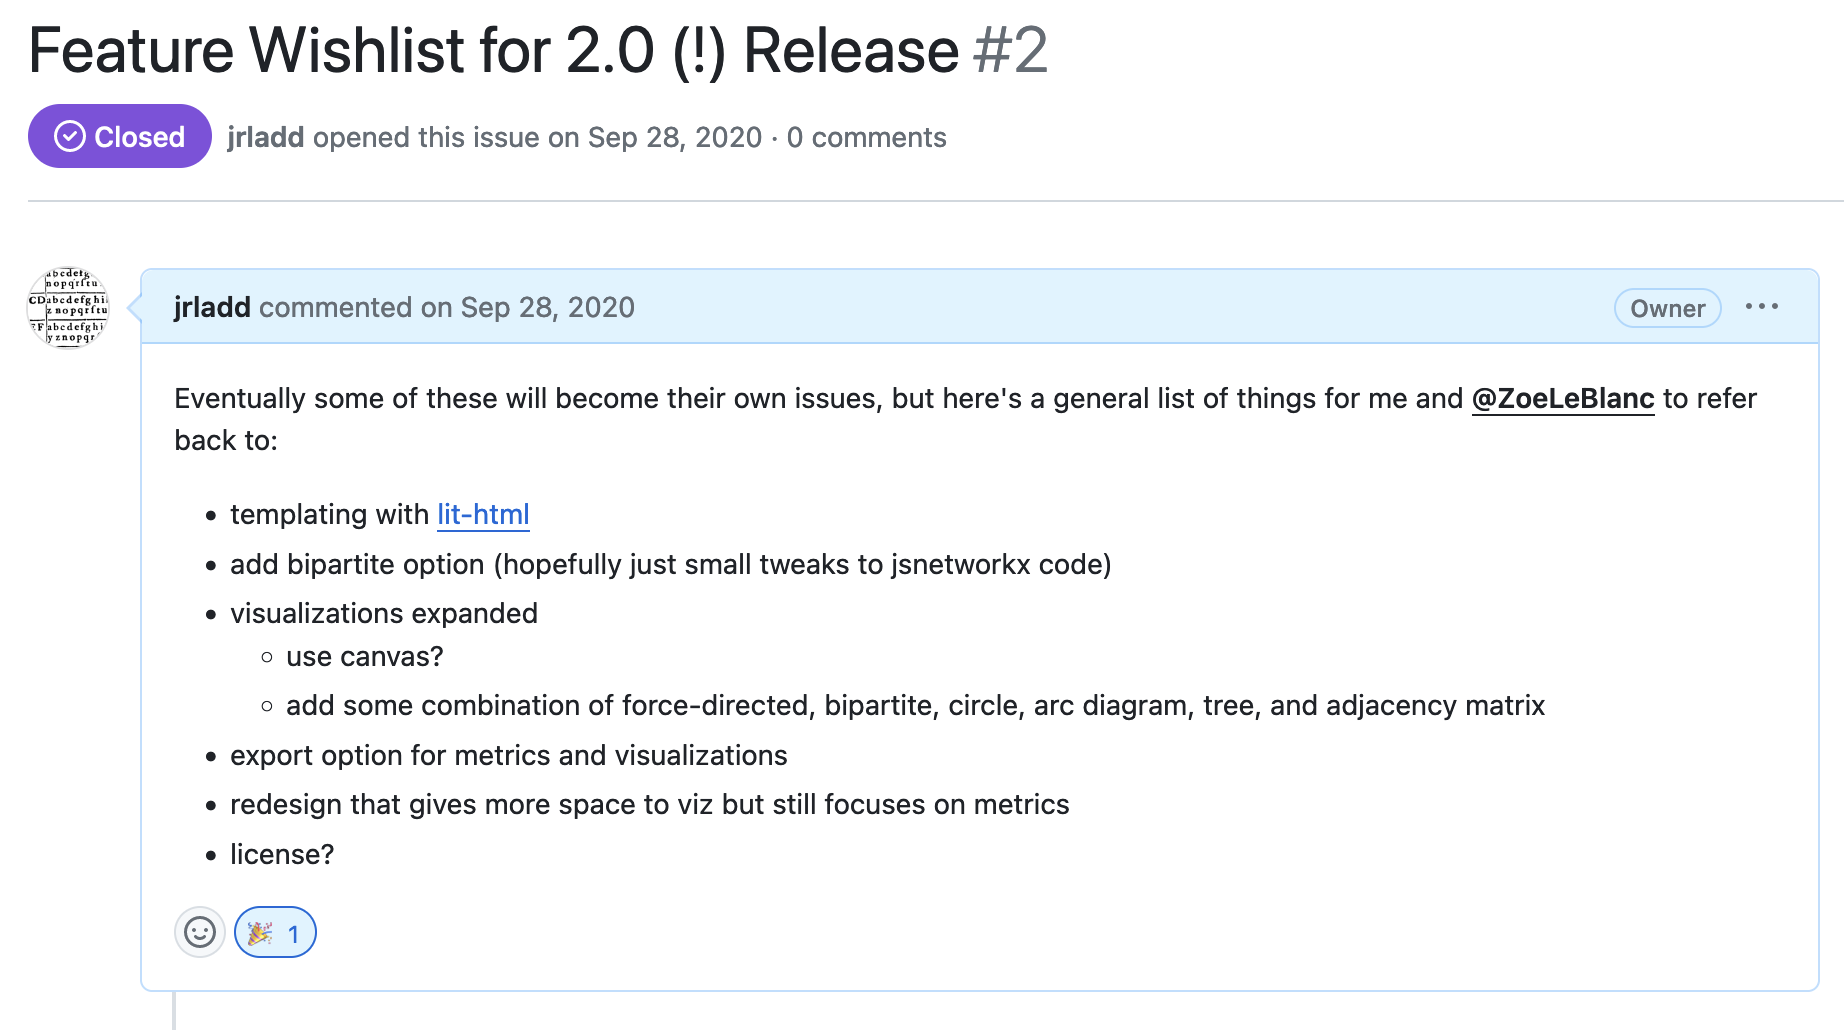

In [35]:
from IPython.display import Image 
metadata={
    "jdh": {
        "module": "object",
        "object": {
            "type":"image",
            "source": [
                "First Issue in the Network Navigator GitHub Repository. Screenshot from https://github.com/jrladd/network_navigator/issues/2"
            ]
        }
    }
}
display(Image("media/nn_feature_wishlist.png"), metadata=metadata)

At their first meeting on September 28, 2020, the two developed a dream wish list of features that included using new HTML templating libraries like lit-html; adding functionality for bipartite networks; expanding visualizations; exporting metrics and visualizations; updated license; and most profoundly, a redesign that balanced visualizations with metrics. While these features may sound straightforward or obvious considering the initial *Network Navigator* interface, these were instead the result of much debate over how to leverage some of the latest technologies in web design and graphics, while also considering how to maintain a lightweight software design.

To that end, the first step was removing the Bootstrap styling library. Originally developed by Twitter in 2010 and publicly released in 2011, Bootstrap is a front-end framework that provides boilerplate code for styling web applications and websites (for instance, organizing columns, designing modal windows, implementing collapsible tables, or incorporating sizable buttons, etc.). Since its release Bootstrap has become incredibly popular, especially for single page applications (SPA), and is currently the eighteenth most starred repository on GitHub. This popularity is in part because Bootstrap makes it far easier to have responsive and aesthetic web applications, which previously required hand-coding many complicated styling elements. However, in our discussions we increasingly became concerned that Bootstrap was delimiting what was possible with the *Network Navigator* interface, rather than enabling our vision. Furthermore, adding Bootstrap to a project necessitates a massive styling library on each page load, which adds a lot of unnecessary weight to a small web project, especially considering that our interface was using few of its features. Part of our reconsideration of Bootstrap was also a larger discussion of whether we should use an even more robust web framework, like React or VueJS (both of which we had previous experience with). However, if Bootstrap was adding too much bloat, then these massively complex web frameworks were never going to be a great fit, especially considering our commitment to the principles of minimal computing and transparent tool design. Instead, though we considered using an HTML templating framework like lit-html, we decided to keep *Network Navigator* as lightweight as possible, hand coding our HTML and Javascript files (though we do utilize the JQuery library). We also decided to opt for lighter styling frameworks, in our case the library Tachyons, to have  finer-grained control over the site’s appearance and distinguish it from other web interfaces, but without having to create custom CSS code that would be difficult to maintain over time. Ultimately, for us, it became important to interrogate the tool we were making, as well as the tools we were using to build the user interface itself. Our choices are also part of the growing un-adoption of modern web frameworks, as more and more developers realize that these frameworks, though helpful, are not the solution or a good fit for every web application or project (<cite data-cite="14009734/PRVIMZCY"></cite>).

For more on Bootstrap see <https://getbootstrap.com/docs/4.0/about/history/> and <https://github.com/EvanLi/Github-Ranking/blob/master/Top100/Top-100-stars.md>. While benchmarking the size of a library is somewhat dependent on internet bandwidth, earlier versions of Bootstrap could be up to ~116 KB when uncompressed (which does not include the Javascript files or other dependencies): <https://stackoverflow.com/questions/29288592/bootstrap-min-css-size-from-cdn-shows-a-surprising-size-in-devtools>.

For more on our adoption of Tachyons, see <https://github.com/jrladd/network_navigator/issues/3> and <https://github.com/jrladd/network_navigator/pull/7>.

While the roads not taken with *Network Navigator* may be difficult to discern for users, we have attempted to build an interface for *Network Navigator* that intentionally makes users aware of itself as a structuring argument (in Drucker and Svensson’s sense). Specifically, the interface design is meant to guide the user to greater understanding of the capabilities of network analysis as a whole but also the intentional limitation of *Network Navigator* as a tool. Our emphasis on limitations may seem like a rationale, or dare we say even an excuse, for not building more functionality, but as stated previously, from the outset *Network Navigator* was designed to be more limited than a tool like *Gephi* since we see it as one part of a broader ecosystem. Therefore, the interface was crafted to encourage users to confront these limitations, which we believe helps them better understand what tools, libraries, and platforms for network analysis that they want to use next. For us then, assessing the usability of *Network Navigator* required thinking as much about what we wanted to omit or obscure from *Network Navigator* versus what we wanted to enable with this tool.

A central way in which *Network Navigator* calls attention to the many possibilities of network analysis is through its prominent presentation of a selected set of network metrics. Shortly before *Network Navigator* was first designed, the team members of *Six Degrees of Francis Bacon* created a tutorial for *The Programming Historian* that outlined how to calculate standard network metrics in Python (<cite data-cite="962389/BP37DLUU"></cite>). The metrics included density, average shortest path length, diameter, and transitivity to measure the whole network, and degree, betweenness centrality, and eigenvector centrality to measure individual nodes. These metrics were chosen because they were already in regular use by the project team, and because the team noted these same metrics frequently occurring in other humanities network projects. 

When first working with network data, humanities scholars are typically interested in two things: the importance of individual nodes and the overall network structure. Local metrics such as degree, betweenness, and eigenvector centrality are essential metrics for understanding a node’s importance. How central is a particular node in the network? Is a specific individual a hub (someone with a lot of connections) or a broker (someone who stands between several groups)? Global metrics such as density, average shortest path length, diameter, and transitivity all give a sense of the overall size and shape of a network. Is the community close-knit or spread out? Would information travel through the network quickly or slowly? The addition of these global metrics was the very first improvement to the site, made in its second commit on the next day, Aug. 9th. Below is a brief demonstration of how to calculate these metrics in Python, and the code outputs a table in a nearly identical way to the first version of *Network Navigator*.

In [36]:
import networkx as nx
import pandas as pd

# Read CSV file
edgelist = pd.read_csv("https://raw.githubusercontent.com/melaniewalsh/sample-social-network-datasets/master/sample-datasets/quakers/quaker-edges.csv")

# Create Graph Object
G = nx.from_pandas_edgelist(edgelist, source="Source", target="Target")

# Calculate Graph-level metrics
print(f"""
Data on the Six Degrees of Francis Bacon Quakers Group:

{G}
Density: {nx.density(G):.4f}
Diameter: {nx.diameter(G)}
Avg. Shortest Path Length: {nx.average_shortest_path_length(G):.4f}
Transitivity {nx.transitivity(G):.4f}
""")

# Calculate Node-level metrics
degree = nx.degree_centrality(G)
betweenness = nx.betweenness_centrality(G)
eigenvector = nx.eigenvector_centrality(G)

# Add attributes to graph
nx.set_node_attributes(G, degree, 'degree_centrality')
nx.set_node_attributes(G, betweenness, 'betweenness_centrality')
nx.set_node_attributes(G, eigenvector, 'eigenvector_centrality')

# Convert node table to Pandas DataFrame for display
nodes = pd.DataFrame.from_dict(G.nodes, orient='index')
nodes.reset_index(level=0,names="name",inplace=True)
nodes.sort_values("degree_centrality", ascending=False)


Data on the Six Degrees of Francis Bacon Quakers Group:

Graph with 96 nodes and 162 edges
Density: 0.0355
Diameter: 8
Avg. Shortest Path Length: 3.3789
Transitivity 0.1695



,name,degree_centrality,betweenness_centrality,eigenvector_centrality
3,George Fox,0.231579,0.366149,0.449175
4,William Penn,0.189474,0.371038,0.270317
34,James Nayler,0.168421,0.161498,0.335301
16,Margaret Fell,0.136842,0.187174,0.253171
2,George Whitehead,0.136842,0.195294,0.249744
...,...,...,...,...
39,Ellis Hookes,0.010526,0.000000,0.061067
43,William Mucklow,0.010526,0.000000,0.061067
46,John Whitehead,0.010526,0.000000,0.033954
55,Dorcas Erbery,0.010526,0.000000,0.045585


The code above reflects the current approach that *Network Navigator* takes to calculating metrics. The site uses JSNetworkX, a JavaScript library that ports many of features of NetworkX, a Python library for network analysis first built by Aric Hagberg, Dan Schult, and Pieter Swart and released in 2005, that has since become one of the main coding libraries for working networks (<cite data-cite="14009734/SK4RM6KG"></cite>). JSNetworkX was built by Felix Kling from 2012 to 2015, and though Kling is no longer maintaining the project, we still decided to use his code for a few reasons. First, though network analysis is a very popular computational methodology, most projects use programming languages like Python or R to compute network metrics, rather than doing so in the browser. Consequently, there remain few alternatives to JSNetworkX for computing these calculations for projects that do not have any backend databases like ours. To limit the potential issues of using unmaintained code, we copied the minified version of JSNetworkX library, and loaded it directly from our project, rather than relying on a Content Delivery Network (CDN) version (which is how most web applications utilize external code libraries). Our second reason for utilizing JSNetworkX is primarily pedagogical. We believe keeping the network functionality consistent across programming languages and DH tools is crucial for enabling both users experienced with network analysis to quickly understand the tool’s functionality (for example, instructors in a DH course) and for helping those new to network analysis to learn about these methods in a way that is transferable (for example, should they decide to eventually learn Python and NetworkX) and consistent with scholarly practices, since the algorithms in NetworkX are widely used in DH and computational research. 

For more information on NetworkX, see https://networkx.org/documentation/stable/developer/about_us.html, and for more information on JSNetworkX, see https://felix-kling.de/jsnetworkx/ .

Using these established node-level metrics, with a familiar library, was part of the initial commit of the site’s code, the very first time the tool appeared on the web:

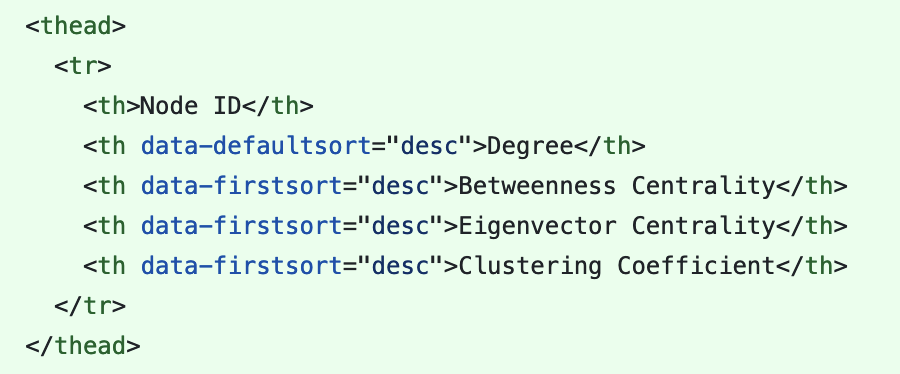

In [37]:
from IPython.display import Image 
metadata={
    "jdh": {
        "module": "object",
        "object": {
            "type":"image",
            "source": [
                "First Commit in the Network Navigator GitHub Repository, showing the HTML for the first metrics table. Screenshot from https://github.com/jrladd/network_navigator/commit/10ad7fd45831980980d26bdacc2913a2fb1fb23c#diff-0eb547304658805aad788d320f10bf1f292797b5e6d745a3bf617584da017051"
            ]
        }
    }
}
display(Image("media/nn_first_commit.png"), metadata=metadata)

Early in the redesign, this sortable Bootstrap table was replaced with the DataTables library to enable easier search, sorting, and especially export. With this change users could explore these metrics outside of the tool, adding their own custom visualizations and pursuing new research questions as needed. Making it easy to get data both in and out of the tool was a central principle of the redesign. Since this wouldn’t be a single-tool approach to network analysis, we wanted users to be able to easily move output from one tool to another. DataTables also enabled a similar logic internally: we were able to create visualizations that would respond to users interacting with the table. If a user searched or filtered the table, the visualization would be filtered accordingly, reinforcing that visualization and metrics exist in conversation with one another. During the *Network Analysis+Digital Art History* workshop in Summer 2019, just one week after Ladd and LeBlanc first discussed redesigning *Network Navigator*, members of the *Palladio* team saw the 1.0 version of *Network Navigator* and proposed that the tool’s metrics be incorporated inside *Palladio*. While working on the *Network Navigator* redesign, Ladd helped adapt the *Palladio* code to include a metrics panel, still available in that tool today. To say that *Network Navigator* is part of a community of network tools is more than metaphoric, since parts of it are now literally embedded in other humanities network tools.

The partnership with *Palladio* throws another portion of the redesign process into relief: our choice not to create functionality for bipartite networks, or networks with more than one type of node. Bipartite network functionality is mentioned in that first feature wishlist screenshotted above: bipartite networks are very common in arts and humanities research, as these areas often deal with connections between people and artistic or historical objects (and thus two distinct node types). As the authors of *The Network Turn*  point out, creating network data from humanities sources is not always straightforward, but modeling relationships as multipartite networks can be a useful way to proceed (<cite data-cite="14009734/6G36YAJC"></cite>). *Palladio*, because it is built for different kinds of humanities data, also users to visualize bipartite networks through prompting the user to select two different columns of data to link (though their actual network graph does not easily distinguish bipartite nodes whether through color or placement). While this choice makes perfect sense for *Palladio*, it was an ongoing question whether bipartite networks suited the pedagogical aims of *Network Navigator*. For the redesign, we had initially hoped to introduce users first to the simplest kinds of unipartite networks and increase complexity from there through including some bipartite functionality. However, we quickly realized that enabling bipartite networks would require an in-depth reworking of almost every part of the tool, and some of our libraries, including JSNetworkX, had not yet included bipartite network metric into their APIs. While we could allow users to visualize bipartite networks, without the ability to run algorithms for bipartite networks, any metrics we would present would ultimately be statistically misleading. 

Thus, we decided not to include bipartite networks for three distinct reasons. First, bipartite options might distract or confuse the very researchers that were hoping to welcome into the field of network analysis, especially deciding how to represent a bipartite network as a unipartite one is an important choice that should be informed by the particular research question. Second, the tools and libraries we were working with were not yet ready to be used for bipartite networks, and given our time constraints as researchers and not full-time developers, we were hesitant to create custom Javascript libraries for bipartite networks that would require significant maintenance. And our third and final reason was that other tools, especially *Palladio*, were already providing researchers with a useful interface to visualize bipartite networks, allowing them to select `source` and `target` nodes, and we did not want to enable visualizations that would not correspond to our metrics. Indeed, many existing network analysis tools allow users to important bipartite graphs and run network analysis algorithms, but do not explain in-depth how these algorithms presume unipartite structures, leading to either confusion or misinterpretation of these metrics. We have come to recognize this decision as a pivotal one for the project, and it has illustrated for us the importance of focus and the careful consideration of what not to do. This decision was confirmed when, since building *Network Navigator*, other useful tools for creating unipartite networks from bipartite networks like *Table2Net* have emerged and joined the community of humanities network analysis applications (<cite data-cite="14009734/EBW9XV83"></cite>) .

The same kinds of design trade-offs and decision making drove the massive changes we made to visualization in the 2.0 version of *Network Navigator*. A goal of the 1.0 version was to subordinate visualization to metrics,  though this needed serious revision in the site’s second version. Seeing more emphasis on visualization than metrics in many tools for beginners (*Gephi*, *Palladio*, *Cytoscape*, etc.), the site sought to make the opposite argument. Instead of creating visualization first, the site implicitly argued that the best way to first get acquainted with a network was through its metrics. To accomplish this, *Network Navigator 1.0* had only a small visualization that wasn’t very customizable, it used the built-in visualizer that came with JSNetworkX. The result was a very simple visualization like the one you see below:

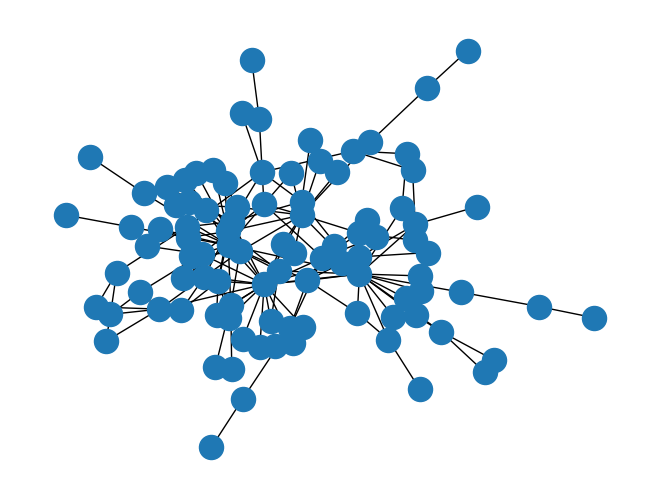

In [38]:
nx.draw(G)

Users could not update node or edge color, node size, position, or any of the typical customizations to which users of network tools had become accustomed. All of this was with the intention of steering the user away from treating a network as a primarily visual tool and toward the computational affordances of networks. Already thinking about the tool as infrastructure, Ladd began here what would become a theme of considering *Network Navigator*’s place within a larger ecosystem of humanities network tools. If other tools did visualization well but lacked detail and refinement for metrics, then *Network Navigator* could and should explore metrics more fully.

This is made evident by the fact that even the visualization, called the “small visualization” in the Github commit, wasn’t added until January of the following year, after Ladd’s work on the custom visualizations in *Six Degrees of Francis Bacon* was complete. The site had been live for six months making metrics available, but even then it was clear that metrics alone wouldn’t be enough for *Network Navigator* to serve as a piece of critical infrastructure.

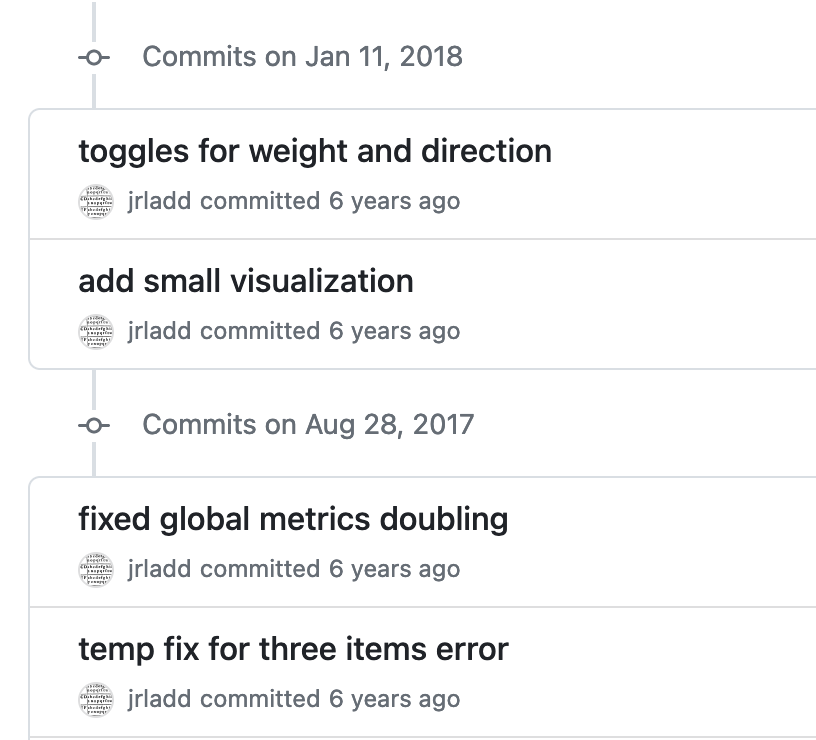

In [39]:
from IPython.display import Image 
metadata={
    "jdh": {
        "module": "object",
        "object": {
            "type":"image",
            "source": [
                "List of Early Commits in the Network Navigator GitHub Repository. Screenshot from https://github.com/jrladd/network_navigator/commits/master/?after=1710da0d54e4bf34cc28cd58cc788b4646f5657b+209"
            ]
        }
    }
}
display(Image("media/nn_commit_list.png"), metadata=metadata)

By showing this small visualization, Ladd initially acknowledged that metrics alone weren’t sufficient for understanding a network, but in early redesign conversation our sense of what helps scholars understand networks evolved considerably. It became clear that many of the metrics, like density, were made much clearer when accompanied by even the simple visualization that the first version of the tool provided and that a more detailed visualization would be a boon to researchers. In becoming a part of the critical DH infrastructure, *Network Navigator* was in conversation with the tools around it, and in learning from our work with *Palladio* and other tools, it became clear that a new interface that could provide both metrics and visualization on equal footing would be the best option. *Network Navigator* could do more to guide researchers toward best practices around network visualization;  it was becoming middleware, an essential learning point between general knowledge of network concepts and the ability to build complex models with more advanced tools. As such it was reaching a group of users  with more needs for visualizations than the 1.0 site could provide.

As the authors of the original *Programming Historian* piece argue, when it comes to visualization and metrics in network analysis, it is impossible to have one without the other (<cite data-cite="962389/BP37DLUU"></cite>). The same is true in other forms of exploratory data analysis as well—good visualization lets you see aspects of the data that are difficult to understand fully with statistics alone, and vice versa. *Network Navigator* has tried to embrace exploratory data analysis (EDA), which as Taylor Arnold and Lauren Tilton argue, “undergirds quantitative work in the digital humanities, particularly text analysis, and yet is rarely explicitly named as a key method or identified as a powerful approach in the field” (<cite data-cite="14009734/HZNZDXYN"></cite>, 293). De-emphasizing visualization in *Network Navigator* 1.0 brought metrics to the foreground, but it made it difficult for users to fully engage in EDA and to understand their data. The central idea of *Network Navigator 2.0*, then, was to put visualization and metrics on equal footing and to show as much as possible how each relied on the other. Most of the items in the “Feature Wishlist” that began this section deal with creating a more flexible visualization structure that would respond to and enhance what *Network Navigator* was trying to show about metrics. This can be seen in more detail in the notes from our October 20th meeting, in which we explored a number of technical ways to integrate visualizations and metrics. The list below thinks about the responsive sizes of visualizations for different screen and panel sizes, downloading both metrics and visualizations, and adding histogram plots to the metrics panel that can adjust and reflect what is shown in the visualization panel.

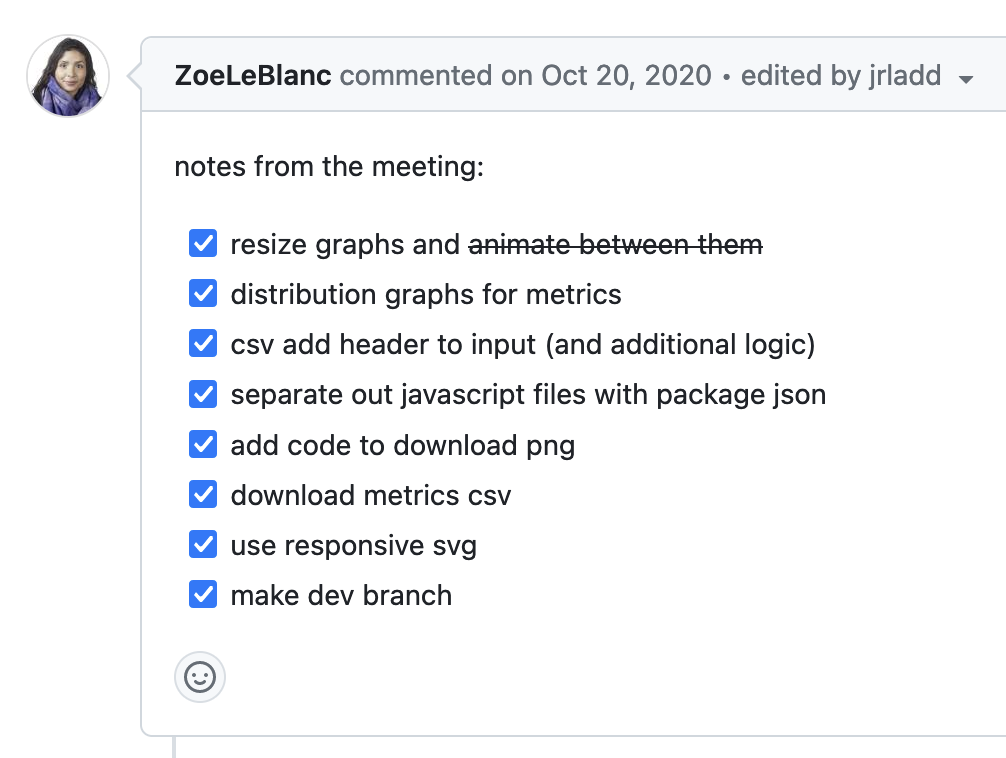

In [40]:
from IPython.display import Image 
metadata={
    "jdh": {
        "module": "object",
        "object": {
            "type":"image",
            "source": [
                "Notes from Oct. 20th Meeting in the Network Navigator GitHub Repository. Screenshot from https://github.com/jrladd/network_navigator/issues/5"
            ]
        }
    }
}
display(Image("media/nn_october_meeting.png"), metadata=metadata)

Our desire to create a more robust set of visualizations for *Network Navigator* coincided with a number of interface principles and developments from our discussion of minimal computing in the previous section. Since the development of tools like *Gephi*, browser capabilities for network visualization have advanced to the point where a browser-based tool can do as much as a desktop application. This is primarily thanks to the D3.js library and, more recently, WebGL, which have greatly expanded both the possibilities for manipulating data and handling larger quantities of data within web browsers. The use of D3 was a major part of several humanities network analysis projects, including *Palladio* and the redesign of *Six Degrees of Francis Bacon*, and the visualization features of *Network Navigator* take advantage of D3's interactive capabilities. D3, which stands for data-driven documents, is a tool for attaching data to visual objects in the browser using the SVG or Canvas web standards (https://d3js.org). At the time it was one of the few tools that could handle the level of visual flexibility that we wanted for *Network Navigator*, but it is limited by the amount of nodes and edges it can display at one time. Often humanities networks are larger than what the browser can display using SVG, and this is why humanities tools have come up with novel ways of dividing large networks, such as SDFB’s method of displaying only 2-degree ego networks and never the full graph. A newer web standard, WebGL (Web Graphics Library), has made it possible to display hundreds or thousands more points in the browser while maintaining the interactivity that D3 provides (https://www.khronos.org/api/webgl). We discussed the trade-offs between WebGL and D3 early in the design process, and because WebGL tools for creating networks were still brand new, D3 was still the best option. However, as the creators of D3 themselves point out, “D3 makes things possible, not necessarily easy; even simple things that should be easy are often not” (https://d3js.org/what-is-d3#d3-is-for-bespoke-visualization). We wound up writing much more JavaScript code than we would need to today to produce the same visualizations. Only just being refined at the time of our redesign, higher-level libraries Graphology and Sigma.js, built on top of WebGL by the SciencesPo médialab, allow very large networks to be displayed in the browser with less code (https://graphology.github.io/, https://www.sigmajs.org/). These libraries power the new *Gephi Lite* web tool, released by *Gephi* in 2022, which allows large force-directed network visualizations to be made in the browser. A similar approach could be taken by *Network Navigator* in the future to expand the size of networks that it can accept. But unlike *Network Navigator*, while *Gephi Lite* allows the user to calculate network metrics in order to customize the visualization, it doesn’t display or allow export of those metrics. In the three years since *Network Navigator 2.0* was developed, browser capabilities for network visualization have only increased, and by using D3 to display networks in a range of layouts, *Network Navigator* was at the forefront of these changes.

We set about to take advantage of all the customization and interactivity that D3 would offer: *Network Navigator* could offer easy switching between a variety of network layouts, it could allow the user to filter based on metadata of their choice, and it could let researchers customize the color, size, and shape of their visualizations. But we chose to do this in such a way that visualization would be integrated with and equal to (but never superseding) what the site was already featuring in its metrics. This resulted in an interface which allows the user to easily move back and forth between the two views or see both at once. Other network analysis tools offer two views, but often on completely separate panels or pages---by offering them side by side we emphasized that their equal importance and kept the site to a minimal number of pages, with fewer interfaces for a new user to learn. That is to say, the *Network Navigator* interface is the result of careful consideration of the rhetorical force of its organizational choices. What does it mean that so many network tools have metrics on a separate page or in a pop-up window? What does it mean to have those metrics appear on the page by default? The overall goal is not just to create something easy to use for people who already understand network analysis, but to provide guidance to researchers who are just starting out about what network analysis can accomplish visually and computationally. What follows is an in-depth description of the visualization features of the site and how they are integrated into *Network Navigator*.

It’s notable that all of these libraries were made by academic researchers or with those researchers in mind: Mike Bostock worked on D3 with Jeffrey Heer and Vadim Ogievetsky of the Stanford Vis Group, which has since become the University of Washington’s Interactive Data Lab (http://vis.stanford.edu/papers/d3), and Graphology and Sigma.js were developed by network researchers at SciencesPo médialab (https://medialab.sciencespo.fr/en/tools/).

The page layout in *Network Navigator* was further complicated by the need for a mobile interface with collapsing columns. This was another point of detailed discussion during the development process. When a user visits the page on a smartphone or table, there may not be enough room to display visualizations and metrics side-by-side, but in this case the columns “collapse” to appear one on top of the other. Even in the mobile interface, both metrics and visualizations are available on the first page of results.

In [ ]:
from IPython.display import Image 
metadata={
    "jdh": {
        "module": "object",
        "object": {
            "type":"image",
            "source": [
                "Changing visualization types in Network Navigator 2.0"
            ]
        }
    }
}
display(Image("media/select_viz.gif"), metadata=metadata)

The image above shows the current *Network Navigator* interface with the *Game of Thrones* network loaded. This dataset is part of Melanie Walsh's curated social network datasets and was first collected by A. Beveridge and J. Shan in their "Network of Thrones" article for *Math Horizons Magazine* (available for download in this GitHub repository https://github.com/melaniewalsh/sample-social-network-datasets). Because of both its size and its similarity to other co-occurrence networks derived from fiction, which are common in humanities network analysis, it was frequently used for internally testing the *Network Navigator* visualization tools.

Three prominent buttons at the top of the visualization panel let the user switch between "Force Layout," "Arc Diagram," and "Adjacency Matrix" visualization layouts. Network analysis tools of the 2010s privileged force-directed layouts that attempt to organize nodes into communities. This led to a boom in humanities network visualization of so-called “hairball” layouts—attempts at force-directed display of a network that wind up showing an unreadable jumble of overlapping nodes and edges. *Network Navigator* provides a Force Layout option that creates a force-directed node-link diagram, and the implementation for this layout comes from D3 and is similar to Gephi's ForceAtlas and ForceAtlas2 layouts. For many, this visualization type is synonymous with network, but it was important to us that *Network Navigator* be as clear as possible that this was one of many visualization options. A newcomer to network analysis may not even realize that other visualization styles are possible or, in many cases, preferable. The interface choice of large layout buttons reinforced the pedagogical point of the site’s new Visualization panel: if one layout of your network isn’t showing anything useful, there’s no reason to continue with it. Instead, try a new layout that emphasizes something different. No other network analysis tool was offering multiple visualization types in this way. *Palladio* displays only a force-directed node-link diagram. *Gephi* presents a number of layout algorithm options, but most of these are for different variations of node-link diagrams, and none of these tools provides a matrix visualization. To provide the user with more options, we settled on three layouts—rather than overwhelming users with too many layout choices, we wanted to give a few key options that would underscore the main point and prepare the user for more detailed visualization tools.

This prominent placement is meant to reinforce the idea that there is no single layout that is well suited to all networks and all research questions. The Force Layout is good at showing communities and structural holes, but it obscures rankings and can sometimes become so dense that the graph is difficult to read. It works well for the *Game of Thrones* network, but with larger networks this layout often produces the dreaded "hairball" visualization. It also prompts particular kinds of questions about community and proximity in networks that may not be a researcher's main interest or reason for creating the network. The other two types of visualizations we provide are far less common in network visualization, and by putting them on equal footing with the force layout our hope is to encourage researchers to embrace non-force-directed visualization approaches.

The Arc Diagram is a rectilinear layout—it arranges nodes in a line, and it displays edges as arcs so that they are visible above or next to the line. Our version of the Arc Diagram is available in both horizontal and vertical arrangements, depending on the preference of the user. Rectilinear layouts are most useful when the order of nodes is important. The ordering could help to show change over time, to sort nodes by network metrics, or to make particular nodes and subgroups easier to find. The Arc Diagram was meant to emphasize that in a node-link diagram the nodes can be positioned in any way that is helpful for the researcher or viewer and need not follow a force-directed pattern.

By contrast, the final visualization layout, the Adjacency Matrix, shows that networks can be visualized without node-link diagrams at all. An adjacency matrix visualizes nodes in rows and columns according to the mathematical representation of a graph that represents the presence or absence of an edge as a table full of 1s and 0s. In an adjacency matrix visualization of a unipartite network (one with just one type of nodes) the rows and columns both represent all the nodes in the network. In the cells where those nodes intersect, a color is displayed when a connection is present. Instead of representing nodes as circles and edges as lines between them, the adjacency matrix represents nodes as rows and columns and edges as color-filled cells. When the weight of the connection is greater, the shading in the cell is darker. Node-link diagrams like the Force Layout and Arc Diagram become very hard to read when a graph is very dense: there are too many edges to be visualized cleanly and the graph winds up a jumble of lines in all directions. Adjacency matrices automatically display a dedicated cell for every *possible* edge in the network, and therefore the visualization doesn't get any more visually complex as the graph gets denser. In a very dense network, there would simply be more colorful cells than blank ones in the adjacency matrix representation. Furthermore, we also hope that the Adjacency Matrix will encourage users to understand that networks can be conceived of and operationalized as matrices. Too often network analysis is treated as completely distinct from other methods of data analysis, whether clustering or dimensonality reduction algorithms, so we intended this visualization to also help users see these connections, especially as they continue to learn computational methods for representing and analyzing their data.

In providing three visually distinct forms of visualization and making them very easy to switch between, *Network Navigator 2.0* aims to instruct its users, by showing rather than telling, that network visualization can take many different possible forms and that even within this interface's relatively small set of visual possibilities there's still a huge amount of control the researcher has over customization and the look and ultimately the visual rhetoric of their graph. And we made sure that all of this could happen within the browser, taking advantage of then-recent advances in Javascript and browser capabilities to provide functions that would previously have required installing a desktop application with a much heavier footprint. This makes a big difference for the classroom as well: rather than needing to devote time to installation and troubleshooting, an instructor can more immediately begin working with students on the network itself. The minimal computing approach is in this case not only the most equitable and matches most closely with our theoretical aims for the project, it is also the most practical approach. And the same browser technologies that make it fast to create the network make it equally quick to edit and alter the network’s structure.

After getting the visualization itself working the way we wanted through different layouts, we were able to spend time and attention on allowing users to customize that visualization. We did this knowing that our features for visualizing would never be as detailed as other tools in the ecosystem, but we felt there should be a tool that provided a first step, a glimpse of what was possible, with sensible guardrails. A more limited set of editing tools would allow a researcher to get a feel for adjusting their network without having to learn a  complex interface or getting in so deep that it was impossible to start again or go back to a previous version. That is, by staying simple, *Network Navigator* incorporates both “reversibility and reproducibility” (<cite data-cite="14009734/2RG8L9PE"></cite>).

In [ ]:
from IPython.display import Image 
metadata={
    "jdh": {
        "module": "object",
        "object": {
            "type":"image",
            "source": [
                "Filtering by edge attribute in Network Navigator 2.0"
            ]
        }
    }
}
display(Image("media/attribute_filter.gif"), metadata=metadata)

The image above shows one of the main ways that researchers can control their visualization and adapt it to particular research questions. Many humanities network applications involve change over time, a property with which traditional network visualizations struggle. One of the advantages of working with dynamic JavaScript visualizations is that the networks can be adjusted and updated based on user input. Given attributes on an edge, it's relatively simple in D3 to let the user control the graph based on those attributes.

This is  how *Six Degrees of Francis Bacon* approached the problem of change over time as well. The site lets users visualize a subset of the network based on a beginning and ending year, and they can do the same thing to filter the network based on its algorithmic "confidence" measure. *Network Navigator* does something very similar, but instead of using just a couple pre-selected edge attributes, the site will let you filter based on *any* edge attribute. Users can easily create a time filter, but also a filter for edge weights, type of relationship, or any additional data that they’ve recorded about their edges.

In the "Customize Graph" panel, you can select an attribute to use as a filter from a dropdown menu. After specifying whether this attribute is a continuous (numerical) variable or a categorical one, you can select a subset of that attribute to filter. If the attribute is categorical, for example a variable that shows a type of relationship (familial, professional, friendship, etc.), the filter will be displayed as a series of radio buttons, allowing the user to select the category they'd like to display. If the attribute is numerical, the filter will be displayed as a histogram showing that attribute's distribution through the graph. The user can select a shaded bounding box around parts of the histogram to filter a specific range of that variable (as you see above).

In network visualization there is often an impulse to show the entire network at all times, but this impulse frequently runs counter to the research questions being asked, which typically involve particularly parts or segments of the overall network. The site's easy-to-use filtering tools to emphasize that visual simplicity is often the best way to make an argument in and through network visualization.

In [ ]:
from IPython.display import Image 
metadata={
    "jdh": {
        "module": "object",
        "object": {
            "type":"image",
            "source": [
                "Customizing force layout graphs in Network Navigator 2.0"
            ]
        }
    }
}
display(Image("media/customize.png"), metadata=metadata)

The customize window does much more than just filter the graph. Visualization is full of critical choices about how to display aspects of the network. Our goal with the tool is not only to be critical makers ourselves, but to train the user to be a responsible critic of their own work and the work of others, to consider and test multiple possibilities for metrics and visualization. In response to this, the site tries to make a limited number of choices available to users of the web interface. While there aren't as many customization options available as in a tool like *Gephi*, the goal was to allow a reasonable amount of the most common visualization adjustments in order to highlight for users how those visual choices alter the arguments they are able to make about their networks.

A key example of this is in the size and color of nodes. Node size and sequential color scaling can both be based on the different degree measurements that *Network Navigator* calculates. This allows a user to make node size reflect degree and node color reflect betweenness, effectively highlighting a network's pivotal nodes. And node attribute customizations are meant to reflect the relationship between metrics and visualizations. User interactions in the metrics panel, for instance changing the histogram from degree to eigenvector centrality, will also update the network visualization. In this way, a user can learn how metrics and visualizations are intertwined and the ways in which visual choices rely on a strong understanding of the mathematics of network analysis. The initial purpose of the tool, to foreground metrics and fill a niche within the larger infrastructure of tools for networks in DH, stayed with *Network Navigator* all the way through this later stage of development. By making adjustments on the metrics side of the site, the visualization is changed commensurably.

Other visual customizations reflect similar relationships. For instance, when a researcher labels their network as Directed when entering data, the visualization automatically includes arrows showing the direction of an edge. Similarly, edge thickness will be mapped to weight when a Weighted network is selected. This reinforces the idea that high level choices about the *kind* of network a researcher is working with will lead to certain conventional visualization choices. But all of these choices can also be directly altered by the researcher: arrows and edge weights are as easy to turn off as they are to make visible, albeit with caveats about *why* a user may want to add these visual elements. The goal is not to force conventional visualizations on the researcher but instead to give the researcher a set of options and equip them with the information to make good choices. For this same reason, curved edges are automatically turned on for the arc diagram to increase readability but never displayed by default for the force layout. Curved edges are sometimes used to indicate direction, to add visual style, or both. To reduce any confusion between these two uses, this customization is left entirely up to the researcher and never automatically triggered by other choices.

Ultimately the goal is to give the researcher tools for creating an effective and accurate visualization that reflects the properties of their network. By starting with sensible choices but allowing the researcher a great deal of control over the final look of the graph, *Network Navigator* is able to provide guidance to researchers without leaving them feeling overwhelmed by options. A critical approach to infrastructure requires us to take a middle course: to find a place for *Network Navigator* that neither oversimplifies for the beginner nor caters to an imagined “power user” with a foreknowledge of all of the functions they’ll need. By never trying to be a “Killer App,” the site can find a niche within a larger ecosystem and serve a purpose without having to serve *every* purpose.

## Communities: Navigating the Future of DH Tools and Next Steps for *Network Navigator*

This essay arose out of our conviction that the individual choices made about *Network Navigator* detailed above are deeply entwined with the tool’s intervention into existing scholarship and our own experience as DH practitioners. As Julia Flanders puts it in her recent essay “Jobs, Roles, and Tools in the Digital Humanities”: “We can start to see here that there is a reason why digital humanists are so preoccupied with tools, and it is not because tools are important in themselves: it is because they are an irritant. They catalyse something complex and difficult concerning professional identity, scholarly methods and practices, and specific types of expertise” (<cite data-cite="14009734/SA55KBQL"></cite>, 156). Completing the redesign of *Network Navigator* was only half of the work. The other half is this piece, which articulates that particular “something complex and difficult” in which our scholarly practices and technical expertise shape both our professional identities and the uses of the tool. This is why there was equal focus on the components of the tool we included—global and local network metrics, responsive visualizations, flexible interface design—as well as those components we specifically and critically chose to omit—bipartite visualization, undo features, user sign-on, and, overall, our decision to avoid making our tool a "Killer App" for network analysis.

The history and critical discourse around DH tools, as well as the specific examples of network analysis tools for both humanities and non-humanities researchers, provides a solid foundation for understanding the ways that DH tools intersect with research and teaching. But we still need more examples that delve into the specifics of how a DH tool was made, the motivations of who made it, and the ways that a tool fits into its larger ecosystem and scholarly context. We hope that this essay can be an example for how to articulate the intersection of these aims. Flanders continues, “The questions of ‘who is digital humanities?’ and ‘how is digital humanities?’ can evidently be reframed as questions like ‘what are the design goals of our tools?’, ‘when should a tool “just work”?’, and ‘are we tool users, tool builders, or tool theorists?’” (<cite data-cite="14009734/SA55KBQL"></cite>, 156). We have attempted to answer these reframed questions through close examination of *Network Navigator*. Our tool was designed for first-time network researchers and students to get acquainted with both the visual and measurable aspects of network analysis. To accomplish this, it had to “just work” in the browser for a wide variety of users and data, but with enough friction to require users to think carefully about the ways that networks would serve their individual research and teaching aims. Finally, through this experience we have come to identify ourselves as occupying all three of Flanders’s categories: we are tool users, tool builders, and tool theorists when we engage in the complex knot of decision making that results in a tool like *Network Navigator*.

And this triple scholarly activity is felt as we participate in the larger community of researchers that use our and others’ network analysis tools. *Network Navigator* isn’t finished and hopefully will never be fully complete. Our work as tool users inspired us to become tool builders, and we hope that *Network Navigator* can inspire others in the same way. The tool’s current users have already helped us to think about what’s next for the site: perhaps with today’s web technologies an easy form of bipartite network analysis will be possible someday, and maybe the software libraries used by tools like *Gephi Lite* might soon enhance *Network Navigator*’s technical capabilities. Any tool that exists within such a robust community will not remain static. Our aim here has been to describe that community and ecosystem as much as the tool itself, to lay the groundwork for future building, use, and theorizing of this and other network analysis and DH tools.

# Bibliography

<div class="cite2c-biblio"></div>